In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import norm, probplot
import seaborn as sns
plt.rc('font', family='D2Coding')

In [ ]:
# 크롤링 위한 라이브러리
import requests
import json
import dart_fss as dart_fss
from pandas import json_normalize

# test,train 분리 라이브러리
from sklearn.model_selection import train_test_split

# 스케일링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import uniform
from scipy.stats import loguniform
from scipy.stats import randint

# 하이퍼파라미터 
import optuna
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# 분류 모델
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

# 평가지표
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix ,roc_curve, auc, roc_auc_score

In [ ]:
# 경고 메세지 무시하기 위한 코드
import warnings
warnings.filterwarnings(action='ignore')

# 서론

## 분석 배경  
관리종목 지정 이후 주가가 하락하며 투자 손실 발생 가능한 점 확인  
관리종목 지정 경향성이 있는 기업을 조기에 파악하여 투자 의사 결정에 도움을 주기 위함

## 분석 목적  
재무제표 데이터를 활용, 관리 종목으로 지정될 가능성이 높은 기업을 사전에 예측할 수 있는 분류 모델 구축 후 인사이트 제공

## 프로세스  
1. 데이터 수집
   - DART, KIND 관리종목, 비관리종목 크롤링  
2. 데이터 전처리
   - 결측값 처리, 이상치 처리, 지표 계산
3. EDA
   - 변수의 분포 파악
4. 모델링
   - 8가지의 예측 모델 구축
   - 성능 비교 후 최종 모델 선택
5. 결과 분석(인사이트 창출)

※ 참고  
머신러닝 기반 KOSDAQ 시장의 관리종목 지정 예측 연구 - 윤향현 외 3인

# 데이터 수집

## DART 관리종목 회사 재무제표 크롤링

예측 모델 개발과 데이터 분석에 필요한 재무제표 데이터를 DART 사이트에서 크롤링하여 데이터 프레임 구축  
- 필요한 변수 목록  
'당기순이익(손실)', '자본총계', '자산총계', '매출액', '수익(매출액)', '영업이익(손실)','자본금',   
'영업이익', '부채총계', '유동자산', '재고자산', '비유동자산', '비유동부채','유동재고자산',  
'매출원가', '매출채권 및 기타유동채권', '매출채권','당기순이익','영업수익','수익','매출'  

※ 참고  
재무제표 분석을 통한 경영성과 분석(사례 연구 : J 은행의 재무제표를 중심으로) - 윤주홍  

### DART 코스닥 관리종목 회사 재무제표 크롤링
- 출처 : KIND(상장공시시스템)

In [ ]:
url = "https://opendart.fss.or.kr/api/fnlttCmpnyIndx.json"
api_key = '개인API키'

In [ ]:
# 상장 기업들만 df_listed에 담음
dart_fss.set_api_key(api_key=api_key)
corp_list = dart_fss.get_corp_list()
all = dart_fss.api.filings.get_corp_code()
all[0]
df = pd.DataFrame(all)
df_listed = df[df['stock_code'].notnull()]

In [ ]:
# 재무제표 크롤링을 위한 관리종목 기업 명단 불러오기
manage_df = pd.read_excel("관리종목명단.xlsx")

In [ ]:
# '시간' 열을 datetime 형식으로 변환
manage_df['시간'] = pd.to_datetime(manage_df['시간'])

# '시간' 열에서 년도만 추출하여 새로운 열 '년도'에 저장
manage_df['년도'] = manage_df['시간'].dt.year

In [ ]:
# 관리종목 기업 명단 중 년도와 회사명이 중복되어 있으면 하나만 남기고 제거
manage_df = manage_df[['회사명','년도']].drop_duplicates()
manage_df.reset_index(drop=True,inplace=True)

In [ ]:
# 재무제표 추출을 위한 회사명, 년도 리스트
com_nm = manage_df['회사명']
com_year = manage_df['년도']

In [ ]:
# 크롤링할 떄 숫자로 들어가면 인식 X, 문자로 바꿔
com_year= com_year.astype('str')

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
final_df = pd.DataFrame()
predefined_columns = ['회사명','년도','당기순이익(손실)', '자본총계', '자산총계', '매출액', '수익(매출액)', '영업이익(손실)','자본금', 
                       '영업이익', '부채총계', '유동자산', '재고자산', '비유동자산', '비유동부채','유동재고자산',
                       '매출원가', '매출채권 및 기타유동채권', '매출채권','당기순이익','영업수익','수익','매출']

# 각 회사의 데이터를 불러와서 처리
for year, name in zip(com_year, com_nm):
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'thstrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'thstrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        final_df = pd.concat([final_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

In [ ]:
final_df.shape

### 관리종목 회사 전기 재무제표 추출

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
bf_final_df = pd.DataFrame()
predefined_columns = ['회사명','년도','당기순이익(손실)', '자본총계', '자산총계', '매출액', '수익(매출액)', '영업이익(손실)','자본금', 
                       '영업이익', '부채총계', '유동자산', '재고자산', '비유동자산', '비유동부채','유동재고자산',
                       '매출원가', '매출채권 및 기타유동채권', '매출채권','당기순이익','영업수익','수익','매출']

# 각 회사의 데이터를 불러와서 처리
for year, name in zip(com_year, com_nm):
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'frmtrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'frmtrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        bf_final_df = pd.concat([bf_final_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

### 데이터 합치기(당기 재무제표 + 전기 재무제표)

In [ ]:
bf_final_df[['회사명','년도','재고자산','유동재고자산','부채총계','자본총계', '자산총계','매출채권','매출채권 및 기타유동채권','매출액','수익(매출액)','영업이익','영업이익(손실)','자산총계','영업수익','매출','수익']]

In [ ]:
bf_final_df1 = bf_final_df[['회사명','년도','재고자산','유동재고자산','부채총계','자본총계', '자산총계','매출채권','매출채권 및 기타유동채권','매출액','수익(매출액)','영업이익','영업이익(손실)','자산총계','영업수익','매출','수익']]

In [ ]:
# 전기 재무제표 데이터 프레임의 컬럼 이름을 앞에 전기를 붙여 저장
col_name = ['회사명','년도','전기재고자산','전기유동재고자산','전기부채총계','전기자본총계', '전기자산총계','전기매출채권','전기매출채권 및 기타유동채권','전기매출액','전기수익(매출액)','전기영업이익','전기영업이익(손실)','전기자산총계','전기영업수익','전기매출','전기수익']
bf_final_df1.columns = col_name

In [ ]:
print(final_df.shape,bf_final_df1.shape)

In [ ]:
financial_df = pd.merge(final_df,bf_final_df1 ,on=['회사명','년도'])

### 간단한 전처리 후 저장

값에 리스트나 배열로 들어간 경우가 존재  
-> 리스트의 첫번째 값으로 저장

In [ ]:
financial_df['당기순이익(손실)'] = financial_df['당기순이익(손실)'].apply(lambda row: row[0] if row is not None else None)
financial_df['당기순이익'] = financial_df['당기순이익'].apply(lambda row: row[0] if row is not None else None)
financial_df['자본총계'] =  financial_df['자본총계'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [ ]:
# 리스트와 numpy 배열을 처리하여 첫 번째 값으로 대체
def get_first_element(x):
    if isinstance(x, (list, np.ndarray)):
        return x[0]
    else:
        return x

name = ['자본총계', '재고자산', '매출채권', '전기재고자산', '전기자본총계', '전기매출채권']
for i in name:
    financial_df[i] = financial_df[i].apply(get_first_element)

In [ ]:
# financial_df.to_csv('최종관리종목데이터_0705.csv',encoding='cp949')

## DART 코스닥 상장법인 회사 재무제표 크롤링  
- 출처 : KIND(상장공시시스템)

In [ ]:
# 코스닥 상장법인 기업 명단
cos_df = pd.read_excel("코스닥상장법인목록크롤링.xlsx")

In [ ]:
# 관리종목 명단에 같이 존재하는 회사는 제거
cos_nm = list(cos_df['회사명'])
cos_nm_filtered = [item for item in com_nm if item in cos_nm]
cos_nm = [item for item in cos_nm if item not in cos_nm_filtered]

### 비관리종목 회사 당기 재무제표 추출

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
cos_df = pd.DataFrame()
predefined_columns =['회사명','년도','당기순이익(손실)', '자본총계', '자산총계', '매출액', '수익(매출액)', '영업이익(손실)','자본금', 
                       '영업이익', '부채총계', '유동자산', '재고자산', '비유동자산', '비유동부채','유동재고자산',
                       '매출원가', '매출채권 및 기타유동채권', '매출채권','당기순이익','영업수익','수익','매출']
# 2023년 치 재무제표만 추출
year = '2023'
# 각 회사의 데이터를 불러와서 처리
for name in cos_nm:
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'thstrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'thstrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        cos_df = pd.concat([cos_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

### 비관리종목 회사 전기 재무제표 추출

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
bf_cos_df = pd.DataFrame()
predefined_columns = ['회사명','년도','당기순이익(손실)', '자본총계', '자산총계', '매출액', '수익(매출액)', '영업이익(손실)','자본금', 
                       '영업이익', '부채총계', '유동자산', '재고자산', '비유동자산', '비유동부채','유동재고자산',
                       '매출원가', '매출채권 및 기타유동채권', '매출채권','당기순이익','영업수익','수익','매출']


year = '2023'
# 각 회사의 데이터를 불러와서 처리
for name in cos_nm:
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'frmtrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'frmtrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        bf_cos_df = pd.concat([bf_cos_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

### 데이터 합치기(당기 재무제표 + 전기 재무제표)

In [ ]:
bf_cos_df1 = bf_cos_df[['회사명','년도','재고자산','유동재고자산','부채총계','자본총계', '자산총계','매출채권','매출채권 및 기타유동채권','매출액','수익(매출액)','영업이익','영업이익(손실)','자산총계','영업수익','수익','매출']]

In [ ]:
col_name = ['회사명','년도','전기재고자산','전기유동재고자산','전기부채총계','전기자본총계', '전기자산총계','전기매출채권','전기매출채권 및 기타유동채권','전기매출액','전기수익(매출액)','전기영업이익','전기영업이익(손실)','전기자산총계','전기영업수익','전기수익','전기매출']
bf_cos_df1.columns = col_name

In [ ]:
financial_normal_df = pd.merge(cos_df,bf_cos_df1 ,on=['회사명','년도'])

In [ ]:
financial_normal_df.head()

### 간단한 전처리 후 저장

관리 종목할때와 동일

In [ ]:
financial_normal_df['당기순이익(손실)'] = financial_normal_df['당기순이익(손실)'].apply(lambda row: row[0] if row is not None else None)
financial_normal_df['자본총계'] = financial_normal_df['자본총계'].apply(lambda row: row[0] if row is not None else None)
financial_normal_df['당기순이익'] = financial_normal_df['당기순이익'].apply(lambda row: row[0] if row is not None else None)
financial_normal_df['전기자본총계'] = financial_normal_df['전기자본총계'].apply(lambda row: row[0] if row is not None else None)

In [ ]:
# 리스트와 numpy 배열을 처리하여 첫 번째 값으로 대체
def get_first_element(x):
    if isinstance(x, (list, np.ndarray)):
        return x[0]
    else:
        return x

name = ['자본총계', '재고자산', '매출채권', '전기재고자산', '전기자본총계', '전기매출채권']
for i in name:
    financial_normal_df[i] = financial_normal_df[i].apply(get_first_element)

In [ ]:
# financial_normal_df.to_csv('정상기업데이터_0705.csv',encoding='cp949')

# 데이터 전처리

## 관리종목 기업 전처리

In [ ]:
manage_df = pd.read_csv("최종관리종목데이터_0705.csv",encoding='cp949',index_col=0)

In [ ]:
# 저장 과정에서 중복된 변수 제
manage_df.drop(columns='전기자산총계.1',inplace=True)

In [ ]:
# 데이터타입을 숫자로 변경
manage_df['당기순이익(손실)'] = pd.to_numeric(manage_df['당기순이익(손실)'],errors='coerce')
manage_df['재고자산'] = pd.to_numeric(manage_df['재고자산'],errors='coerce')
manage_df['매출채권'] = pd.to_numeric(manage_df['매출채권'],errors='coerce')
manage_df['당기순이익'] = pd.to_numeric(manage_df['당기순이익'],errors='coerce')
manage_df['전기자본총계'] = pd.to_numeric(manage_df['전기자본총계'],errors='coerce')
manage_df['자본금'] = pd.to_numeric(manage_df['자본금'],errors='coerce')
manage_df['매출채권 및 기타유동채권'] = pd.to_numeric(manage_df['매출채권 및 기타유동채권'],errors='coerce')
manage_df['전기매출채권 및 기타유동채권'] = pd.to_numeric(manage_df['전기매출채권 및 기타유동채권'],errors='coerce')
manage_df['전기재고자산'] = pd.to_numeric(manage_df['전기재고자산'],errors='coerce')
manage_df['전기매출채권'] = pd.to_numeric(manage_df['전기매출채권'],errors='coerce')

In [ ]:
# 영업 수익 여부 변수 생성(매출이 영업수익인 경우)
# 매출원가, 재고자산 등에서 차이를 보이기 떄문에 컬럼으로 영업수익 여부를 명시해
manage_df['영업수익여부'] = np.where(manage_df['영업수익'].notnull(),1,0)

### 매출액 변수 전처리

당기 최종 매출액 변수

In [ ]:
# 매출과 관련된 값이 nan이면 삭
idx = manage_df[(manage_df['매출액'].isnull())&(manage_df['수익(매출액)'].isnull())&(manage_df['영업수익'].isnull())&(manage_df['매출'].isnull())].index
manage_df.drop(index=idx,inplace=True)
manage_df.reset_index(drop=True, inplace=True)

In [ ]:
# 매출과 관련된 값을 nan값은 0으로 처리하고 모두 더하여 최종 매출액 변수 생성
manage_df[['매출액','수익(매출액)','영업수익','매출']] = manage_df[['매출액','수익(매출액)','영업수익','매출']].fillna(0)
manage_df['최종매출액'] = manage_df['매출액'] + manage_df['수익(매출액)'] + manage_df['영업수익'] + manage_df['매출']

전기 최종 매출액 변수  
위와 동일

In [ ]:
idx = manage_df[(manage_df['전기매출액'].isnull())&(manage_df['전기수익(매출액)'].isnull())&(manage_df['전기영업수익'].isnull())&(manage_df['전기매출'].isnull())].index
manage_df.drop(index=idx,inplace=True)
manage_df.reset_index(inplace=True,drop=True)

In [ ]:
manage_df[['전기매출액','전기수익(매출액)','전기영업수익','전기매출']] = manage_df[['전기매출액','전기수익(매출액)','전기영업수익','전기매출']].fillna(0)
manage_df['최종전기매출액'] = manage_df['전기매출액'] + manage_df['전기수익(매출액)'] + manage_df['전기영업수익']+ manage_df['전기매출']

### 영업이익 변수 전처리

당기 영업이익

In [ ]:
# 영업이익과 영업이익(손실) 변수 둘 다 nan값인 경우 삭제
idx = manage_df[(manage_df['영업이익'].isnull())&(manage_df['영업이익(손실)'].isnull())].index
manage_df.drop(index=idx,inplace=True)
manage_df.reset_index(inplace=True,drop=True)

In [ ]:
# 영업이익과 영업이익(손실) 두 변수 더하여 최종영업이익 변수 생
manage_df[['영업이익','영업이익(손실)']] = manage_df[['영업이익','영업이익(손실)']].fillna(0)
manage_df['최종영업이익'] = manage_df['영업이익'] + manage_df['영업이익(손실)'] 

전기 영업이익  
위와 동일

In [ ]:
manage_df[['전기영업이익','전기영업이익(손실)']] = manage_df[['전기영업이익','전기영업이익(손실)']].fillna(0)
manage_df['최종전기영업이익'] = manage_df['전기영업이익'] + manage_df['전기영업이익(손실)'] 

필요없어진 변수 drop

In [ ]:
manage_df.drop(columns=['매출액','수익(매출액)','영업이익','영업이익(손실)','전기매출액','영업수익','전기영업수익','매출','전기매출','전기수익(매출액)','전기영업이익','전기영업이익(손실)','수익','전기수익'],inplace=True)

### 당기순이익 변수 전처리

In [ ]:
# 둘다 nan값인 경우 drop
idx = manage_df[(manage_df['당기순이익(손실)'].isnull())&(manage_df['당기순이익'].isnull())].index
manage_df.drop(index=idx,inplace=True)
manage_df.reset_index(inplace=True,drop=True)

In [ ]:
# 두 변수에서 값이 10 이하면 0으로 바꿔
manage_df['당기순이익(손실)'] = manage_df['당기순이익(손실)'].apply(lambda row: 0 if (row <= 10) & (row >0) else row)
manage_df['당기순이익'] = manage_df['당기순이익'].apply(lambda row: 0 if (row <= 10) & (row >0) else row)

In [ ]:
# 두 변수의 값이 같으면 둘 중 하나의 값으로 처리.
# 아니라면 더하
def combine_values(row):
    if row['당기순이익(손실)'] == row['당기순이익']:
        return row['당기순이익']
    else:
        return row['당기순이익(손실)'] + row['당기순이익']

manage_df[['당기순이익','당기순이익(손실)']] = manage_df[['당기순이익','당기순이익(손실)']].fillna(0)
manage_df['최종당기순이익'] = manage_df.apply(combine_values, axis=1)

In [ ]:
# 필요없어진 변수 drop
manage_df.drop(columns=['당기순이익','당기순이익(손실)'], inplace=True)
manage_df.reset_index(drop=True,inplace=True)

### 재고자산 변수 전처리

In [ ]:
# 재고자산과 유동재고자산이 둘다 nan값이 아니라면 재고자산으로
# 그게 아니라면 nan값은 0으로 채우고 더함 
manage_df['최종재고자산'] = np.where(
    manage_df['재고자산'].notnull() & manage_df['유동재고자산'].notnull(), manage_df['재고자산'],
    manage_df['재고자산'].fillna(0) + manage_df['유동재고자산'].fillna(0)
)

In [ ]:
manage_df['최종전기재고자산'] = np.where(
    manage_df['전기재고자산'].notnull() & manage_df['전기유동재고자산'].notnull(), manage_df['전기재고자산'],
    manage_df['전기재고자산'].fillna(0) + manage_df['전기유동재고자산'].fillna(0)
)

In [ ]:
# 필요없어진 변수 drop
manage_df.drop(columns=['전기재고자산','전기유동재고자산','재고자산','유동재고자산'],inplace=True)

### 매출채권을 의미하는 다른 변수들 추가 크롤링

당기 재무제표 데이터 추출

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
final_df = pd.DataFrame()
predefined_columns = ['회사명','년도','매출채권 및 기타채권','매출채권 및 기타수취채권','매출채권및기타채권','매출채권및기타유동채권','매출채권및기타수취채권']

# 각 회사의 데이터를 불러와서 처리
for year, name in zip(mn_year, mn_name):
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'thstrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'thstrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        final_df = pd.concat([final_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

In [ ]:
final_df['년도'] = final_df['년도'].astype('int')

In [ ]:
# 리스트와 numpy 배열을 처리하여 첫 번째 값으로 대체(리스트와 배열로 값이 들어가 있는 것 대상)
def get_first_element(x):
    if isinstance(x, (list, np.ndarray)):
        return x[0]
    else:
        return x

name = ['매출채권 및 기타채권', '매출채권 및 기타수취채권', '매출채권및기타채권', '매출채권및기타유동채권',
       '매출채권및기타수취채권']
for i in name:
    final_df[i] = final_df[i].apply(get_first_element)

In [ ]:
# 데이터 타입을 숫자로 바꿔주기
final_df['매출채권 및 기타채권'] = pd.to_numeric(final_df['매출채권 및 기타채권'],errors='coerce')
final_df['매출채권 및 기타수취채권'] = pd.to_numeric(final_df['매출채권 및 기타수취채권'],errors='coerce')
final_df['매출채권및기타채권'] = pd.to_numeric(final_df['매출채권및기타채권'],errors='coerce')
final_df['매출채권및기타유동채권'] = pd.to_numeric(final_df['매출채권및기타유동채권'],errors='coerce')
final_df['매출채권및기타수취채권'] = pd.to_numeric(final_df['매출채권및기타수취채권'],errors='coerce')

In [ ]:
# 기존의 관리종목 데이터 프레임에 위에서 추출한 데이터를 회사명, 년도 기준으로 합침
manage_df = pd.merge(manage_df,final_df,on=['회사명', '년도'],how='left')

In [ ]:
# 매출 채권 관련 변수가 모두 nan값이면 삭제
idx = manage_df[(manage_df['매출채권'].isnull())&(manage_df['매출채권 및 기타유동채권'].isnull())&(manage_df['매출채권 및 기타채권'].isnull())&(manage_df['매출채권 및 기타수취채권'].isnull())&(manage_df['매출채권및기타채권'].isnull())&(manage_df['매출채권및기타유동채권'].isnull())&(manage_df['매출채권및기타수취채권'].isnull())].index
manage_df.drop(index=idx, inplace=True)
manage_df.reset_index(drop=True, inplace=True)

In [ ]:
# 매출 채권 관련 변수 중 모두 값이 존재한다면 매출채권을 값으로 넣고
# 그게 아니라면 nan값을 0으로 채워 더하여 최종 매출채권 변수 생성
manage_df['최종매출채권'] = np.where(
    manage_df['매출채권'].notnull() & manage_df['매출채권 및 기타유동채권'].notnull()&(manage_df['매출채권 및 기타채권'].notnull())&(manage_df['매출채권 및 기타수취채권'].notnull())&(manage_df['매출채권및기타채권'].notnull())&(manage_df['매출채권및기타유동채권'].notnull())&(manage_df['매출채권및기타수취채권'].notnull()), manage_df['매출채권'],
    manage_df['매출채권'].fillna(0) + manage_df['매출채권 및 기타유동채권'].fillna(0)  + manage_df['매출채권 및 기타채권'].fillna(0) + manage_df['매출채권 및 기타수취채권'].fillna(0) + manage_df['매출채권및기타채권'].fillna(0) + manage_df['매출채권및기타유동채권'].fillna(0) + manage_df['매출채권및기타수취채권'].fillna(0)
)

전기 재무제표 데이터 추출

In [ ]:
# 결과를 저장할 빈 데이터프레임 및 미리 정의된 컬럼명 리스트
bf_final_df = pd.DataFrame()
predefined_columns = ['회사명','년도','매출채권 및 기타채권','매출채권 및 기타수취채권','매출채권및기타채권','매출채권및기타유동채권','매출채권및기타수취채권']

# 각 회사의 데이터를 불러와서 처리
for year, name in zip(mn_year, mn_name):
    try:
        corp_code = df_listed[df_listed['corp_name'] == name].iloc[0, 0]
    except IndexError:
        print(f"Warning: {name} is not in the listed companies. Skipping...")
        continue  # 이름이 없으면 건너뛰기

    try:
        data = dart_fss.api.finance.fnltt_singl_acnt_all(corp_code, fs_div='OFS', bsns_year=year, reprt_code='11011')
        if not data:
            print(f"No data returned for {name} in {year}. Skipping...")
            continue  # 데이터가 비어있으면 건너뛰기
    except Exception as e:
        print(f"Error fetching data for {name} for year {year}: {e}")
        continue  # 데이터 가져오기 실패시 건너뛰기
    
    # 데이터 변환
    df = pd.DataFrame(data['list'])
    if 'account_nm' not in df.columns or 'frmtrm_amount' not in df.columns:
        print(f"Expected columns not found in data for {name} in {year}. Skipping...")
        continue  # 필요한 열이 없으면 건너뛰기

    try:
        # 필요한 열만 선택하고 피벗팅
        df = df[['account_nm', 'frmtrm_amount']].set_index('account_nm').T
        df['회사명'] = name  # 회사명 추가
        df['년도'] = year

        # 미리 정의된 컬럼명 리스트에 따라 데이터프레임 초기화
        row_df = pd.DataFrame(columns=predefined_columns)
        row_df.loc[0] = [name] + [df[col].values[0] if col in df.columns else None for col in predefined_columns[1:]]

        # 결과 데이터프레임에 추가
        bf_final_df = pd.concat([bf_final_df, row_df], axis=0, ignore_index=True)
        
    except Exception as e:
        print(f"{year}년 {name} 데이터 처리 중 오류가 발생했습니다: {e}")
        continue  # 데이터 처리 중 문제가 생기면 건너뛰기

In [ ]:
# 리스트와 numpy 배열을 처리하여 첫 번째 값으로 대체
def get_first_element(x):
    if isinstance(x, (list, np.ndarray)):
        return x[0]
    else:
        return x

name = ['매출채권 및 기타채권', '매출채권 및 기타수취채권', '매출채권및기타채권', '매출채권및기타유동채권',
       '매출채권및기타수취채권']

for i in name:
    bf_final_df[i] = bf_final_df[i].apply(get_first_element)

In [ ]:
# 위와 동일
bf_final_df['매출채권 및 기타채권'] = pd.to_numeric(bf_final_df['매출채권 및 기타채권'],errors='coerce')
bf_final_df['매출채권 및 기타수취채권'] = pd.to_numeric(bf_final_df['매출채권 및 기타수취채권'],errors='coerce')
bf_final_df['매출채권및기타채권'] = pd.to_numeric(bf_final_df['매출채권및기타채권'],errors='coerce')
bf_final_df['매출채권및기타유동채권'] = pd.to_numeric(bf_final_df['매출채권및기타유동채권'],errors='coerce')
bf_final_df['매출채권및기타수취채권'] = pd.to_numeric(bf_final_df['매출채권및기타수취채권'],errors='coerce')

In [ ]:
# 위와 동일
idx = bf_final_df[(bf_final_df['매출채권 및 기타채권'].isnull())&(bf_final_df['매출채권 및 기타수취채권'].isnull())&(bf_final_df['매출채권및기타채권'].isnull())&(bf_final_df['매출채권및기타유동채권'].isnull())&(bf_final_df['매출채권및기타수취채권'].isnull())].index
bf_final_df.drop(index=idx, inplace=True)
bf_final_df.reset_index(drop=True, inplace=True)

In [ ]:
# 위와 동일
bf_final_df['최종매출채권'] = bf_final_df['매출채권 및 기타채권'].fillna(0) + bf_final_df['매출채권 및 기타수취채권'].fillna(0) + bf_final_df['매출채권및기타채권'].fillna(0) + bf_final_df['매출채권및기타유동채권'].fillna(0) + bf_final_df['매출채권및기타수취채권'].fillna(0)

In [ ]:
# 위와 동일
bf_final_df1 = bf_final_df[['회사명','년도','최종매출채권']]
bf_final_df1.columns = ['회사명','년도','전기매출채권_전']

In [ ]:
# 위와 동일
bf_final_df1['년도'] = bf_final_df1['년도'].astype('int')

In [ ]:
# 위와 동일
manage_df = pd.merge(manage_df,bf_final_df1,on=['회사명','년도'],how='left')

In [ ]:
# 위와 동일
manage_df['최종전기매출채권'] = np.where(
    (manage_df['전기매출채권'].notnull()) & (manage_df['전기매출채권 및 기타유동채권'].notnull())& (manage_df['전기매출채권_전'].notnull()), manage_df['전기매출채권'],
    manage_df['전기매출채권'].fillna(0) + manage_df['전기매출채권 및 기타유동채권'].fillna(0) + manage_df['전기매출채권_전'].fillna(0)
)

In [ ]:
# 필요없어진 변수는 drop
manage_df.drop(columns=['매출채권','매출채권및기타채권','전기매출채권','전기매출채권 및 기타유동채권'],inplace=True)
manage_df.drop(columns=['매출채권 및 기타채권','매출채권 및 기타수취채권','매출채권및기타유동채권','매출채권및기타수취채권'],inplace=True)
manage_df.drop(columns=['전기매출채권_전','매출채권 및 기타유동채권'],inplace=True)

In [ ]:
# 매출원가는 nan값을 0으로 대체
manage_df['매출원가'] = manage_df['매출원가'].fillna(0)

In [ ]:
manage_df.isnull().sum()

결측값으로 되어있는 변수의 수가 얼마 되지 않아 직접 해당 년도, 회사의 재무제표를 찾아서 대체해줌

In [ ]:
# manage_df.to_csv('정제된관리종목_0708.csv',encoding='cp949')

## 비관리종목 기업 전처리

위의 관리종목 기업 전처리 과정과 동일하게 진행

In [ ]:
normal_df = pd.read_csv("정상기업데이터_0705.csv",encoding='cp949',index_col=0)

In [ ]:
normal_df.drop(columns='전기자산총계.1',inplace=True)

In [ ]:
normal_df['당기순이익(손실)'] = pd.to_numeric(normal_df['당기순이익(손실)'],errors='coerce')
normal_df['재고자산'] = pd.to_numeric(normal_df['재고자산'],errors='coerce')
normal_df['매출채권'] = pd.to_numeric(normal_df['매출채권'],errors='coerce')
normal_df['당기순이익'] = pd.to_numeric(normal_df['당기순이익'],errors='coerce')
normal_df['전기자본총계'] = pd.to_numeric(normal_df['전기자본총계'],errors='coerce')
normal_df['자본금'] = pd.to_numeric(normal_df['자본금'],errors='coerce')
normal_df['매출채권 및 기타유동채권'] = pd.to_numeric(normal_df['매출채권 및 기타유동채권'],errors='coerce')
normal_df['전기매출채권 및 기타유동채권'] = pd.to_numeric(normal_df['전기매출채권 및 기타유동채권'],errors='coerce')
normal_df['전기재고자산'] = pd.to_numeric(normal_df['전기재고자산'],errors='coerce')
normal_df['전기매출채권'] = pd.to_numeric(normal_df['전기매출채권'],errors='coerce')

In [ ]:
normal_df['영업수익여부'] = np.where(normal_df['영업수익'].notnull(),1,0)

In [ ]:
idx = normal_df[(normal_df['매출액'].isnull())&(normal_df['수익(매출액)'].isnull())&(normal_df['영업수익'].isnull())&(normal_df['매출'].isnull())].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(inplace=True,drop=True)

In [ ]:
normal_df[['매출액','수익(매출액)','영업수익','매출']] = normal_df[['매출액','수익(매출액)','영업수익','매출']].fillna(0)

In [ ]:
normal_df['최종매출액'] = normal_df['매출액'] + normal_df['수익(매출액)'] + normal_df['영업수익'] + normal_df['매출'] 

In [ ]:
idx = normal_df[(normal_df['전기매출액'].isnull())&(normal_df['전기수익(매출액)'].isnull())&(normal_df['전기영업수익'].isnull())&(normal_df['전기매출'].isnull())].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(inplace=True,drop=True)

In [ ]:
normal_df[['전기매출액','전기수익(매출액)','전기영업수익','전기매출']] = normal_df[['전기매출액','전기수익(매출액)','전기영업수익','전기매출']].fillna(0)
normal_df['최종전기매출액'] = normal_df['전기매출액'] + normal_df['전기수익(매출액)'] + normal_df['전기영업수익']+ normal_df['전기매출']

In [ ]:
idx = normal_df[(normal_df['영업이익'].isnull())&(normal_df['영업이익(손실)'].isnull())].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(inplace=True,drop=True)

In [ ]:
normal_df[['영업이익','영업이익(손실)']] = normal_df[['영업이익','영업이익(손실)']].fillna(0)
normal_df['최종영업이익'] = normal_df['영업이익'] + normal_df['영업이익(손실)'] 

In [ ]:
normal_df[['전기영업이익','전기영업이익(손실)']] = normal_df[['전기영업이익','전기영업이익(손실)']].fillna(0)
normal_df['최종전기영업이익'] = normal_df['전기영업이익'] + normal_df['전기영업이익(손실)'] 

In [ ]:
normal_df.drop(columns=['매출액','수익(매출액)','영업이익','영업이익(손실)','전기매출액','영업수익','전기영업수익','매출','전기매출','전기수익(매출액)','전기영업이익','전기영업이익(손실)','수익','전기수익'],inplace=True)

In [ ]:
idx = normal_df[(normal_df['당기순이익(손실)'].isnull())&(normal_df['당기순이익'].isnull())].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(inplace=True,drop=True)

In [ ]:
normal_df['당기순이익(손실)'] = normal_df['당기순이익(손실)'].apply(lambda row: 0 if (row <= 10) & (row >0) else row)
normal_df['당기순이익'] = normal_df['당기순이익'].apply(lambda row: 0 if (row <= 10) & (row >0) else row)

In [ ]:
def combine_values(row):
    if row['당기순이익(손실)'] == row['당기순이익']:
        return row['당기순이익']
    else:
        return row['당기순이익(손실)'] + row['당기순이익']

normal_df[['당기순이익','당기순이익(손실)']] = normal_df[['당기순이익','당기순이익(손실)']].fillna(0)
normal_df['최종당기순이익'] = normal_df.apply(combine_values, axis=1)

In [ ]:
normal_df.drop(columns=['당기순이익','당기순이익(손실)'], inplace=True)
normal_df.reset_index(drop=True,inplace=True)

In [ ]:
normal_df['최종재고자산'] = np.where(
    normal_df['재고자산'].notnull() & normal_df['유동재고자산'].notnull(), normal_df['재고자산'],
    normal_df['재고자산'].fillna(0) + normal_df['유동재고자산'].fillna(0)
)

In [ ]:
normal_df['최종전기재고자산'] = np.where(
    normal_df['전기재고자산'].notnull() & normal_df['전기유동재고자산'].notnull(), normal_df['전기재고자산'],
    normal_df['전기재고자산'].fillna(0) + normal_df['전기유동재고자산'].fillna(0)
)

In [ ]:
normal_df.drop(columns=['전기재고자산','전기유동재고자산','재고자산','유동재고자산'],inplace=True)

In [ ]:
idx = normal_df[(normal_df['매출채권'].isnull())&(normal_df['매출채권 및 기타유동채권'].isnull())].index
normal_df.drop(index=idx, inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
normal_df['최종매출채권'] = np.where(
    normal_df['매출채권'].notnull() & normal_df['매출채권 및 기타유동채권'].notnull(), normal_df['매출채권'],
    normal_df['매출채권'].fillna(0) + normal_df['매출채권 및 기타유동채권'].fillna(0)
)

In [ ]:
normal_df['최종전기매출채권'] = np.where(
    normal_df['전기매출채권'].notnull() & normal_df['전기매출채권 및 기타유동채권'].notnull(), normal_df['전기매출채권'],
    normal_df['전기매출채권'].fillna(0) + normal_df['전기매출채권 및 기타유동채권'].fillna(0)
)

In [ ]:
normal_df.drop(columns=['매출채권','매출채권 및 기타유동채권','전기매출채권','전기매출채권 및 기타유동채권'],inplace=True)

In [ ]:
idx = normal_df[normal_df['최종매출채권'] == 0].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
idx = normal_df[normal_df['최종매출액'] ==0].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
idx = normal_df[(normal_df['매출원가'].isnull())&(normal_df['영업수익여부']==0)].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
normal_df['매출원가'] = normal_df['매출원가'].fillna(0)

In [ ]:
idx = normal_df[normal_df['자본총계'].isnull()].index
normal_df.drop(index=idx, inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
idx = normal_df[normal_df['자본총계']<=10].index
normal_df.drop(index=idx,inplace=True)
normal_df.reset_index(drop=True, inplace=True)

In [ ]:
normal_df.dropna(inplace=True)

In [ ]:
normal_df.isnull().sum()

In [ ]:
# normal_df.to_csv('최종정제된정상기업_0708.csv',encoding='cp949')

관리종목 기업과 비관리종목기업 합치기

In [388]:
# normal_df = pd.read_csv('최종정제된정상기업_0708.csv',encoding='cp949',index_col=0)
# manage_df = pd.read_csv('정제된관리종목_0708_빈값.csv',encoding='cp949',index_col=0)

In [389]:
manage_df['관리종목여부'] = 1

In [390]:
normal_df['관리종목여부'] = 0

In [391]:
final_df = pd.concat([manage_df,normal_df])

In [392]:
# final_df.to_csv('통합재무제표데이터_0708.csv',encoding='cp949')

## 지표 변수 생성

- 수익성 지표  
총자본순이익률(당기순이익/평균총자본)  
자기자본순이익률(단기순이익/평균자기자본)  
총자산이익률(당기순이익/총자산  
매출총이익률(매출총이익/매출액)  
매출액영업이익률(영업이익/매출액)  
매출액순이익률(당기순이익/매출액)  
- 안정성 지표  
자기자본비율(자기자본/총자본)  
부채비율(부채/자기자본)  
부채구성비율(부채/총자본)  
유동비율(유동자산/유동부채)  
당좌비율(당좌자산/유동부채)  
이자보상비율(영업이익/이자비용  
고정장기적합률(고정자산/(자기자본+고정부채))  
- 활동성 지표  
총자산회전율(매출액/평균총자산)  
자기자본회전율(매출액/평균자기자본)  
재고자산회전율(매출원가/평균재고자산)  
매출채권회전율(순외상매출액/평균매출채권)  
매출채권 평균회수기간(365일/매출채권회전율)   
재고자산 평균회전기간(365일/재고자산회전율)  
- 성장성 지표   
매출액 성장률((당기매출액-전기매출액)/전기매출액)  
이익 성장률((당기영업익-전기영업이익)/전기영업이익)  
자산 증가율( 당기 말 총자산 / 전기 말 총자산)  

In [712]:
# final_df = pd.read_csv('통합재무제표데이터_0708.csv',encoding='cp949',index_col=0)

In [713]:
# final_df.reset_index(drop=True, inplace=True)

In [714]:
# final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   회사명       1406 non-null   object 
 1   년도        1406 non-null   int64  
 2   자본총계      1406 non-null   float64
 3   자산총계      1406 non-null   float64
 4   자본금       1406 non-null   float64
 5   부채총계      1406 non-null   float64
 6   유동자산      1406 non-null   float64
 7   비유동자산     1406 non-null   float64
 8   비유동부채     1406 non-null   float64
 9   매출원가      1406 non-null   float64
 10  전기부채총계    1406 non-null   float64
 11  전기자본총계    1406 non-null   float64
 12  전기자산총계    1406 non-null   float64
 13  영업수익여부    1406 non-null   int64  
 14  최종매출액     1406 non-null   float64
 15  최종전기매출액   1406 non-null   float64
 16  최종영업이익    1406 non-null   float64
 17  최종전기영업이익  1406 non-null   float64
 18  최종당기순이익   1406 non-null   float64
 19  최종재고자산    1406 non-null   float64
 20  최종전기재고자산  1406 non-null   floa

In [715]:
# 먀출액이 0인 행 제외
idx = final_df[final_df['최종매출액'] == 0].index
final_df.drop(index=idx,inplace=True)
final_df.reset_index(drop=True, inplace=True)

In [716]:
# 최종전기영업이익이 0인 행 제외
idx = final_df[final_df['최종전기영업이익'] == 0].index
final_df.drop(index=idx,inplace=True)
final_df.reset_index(drop=True, inplace=True)

In [717]:
final_df['유동부채'] = final_df['부채총계'] - final_df['비유동부채']
final_df['당좌자산'] = final_df['유동자산'] - final_df['최종재고자산']
final_df['총자본'] = final_df['자본총계'] + final_df['부채총계']
final_df['전기총자본'] = final_df['전기자본총계'] + final_df['전기부채총계']

In [721]:
final_df['평균총자본'] = (final_df['총자본'] + final_df['전기총자본'])/2
final_df['평균자기자본'] = (final_df['자본총계'] + final_df['자본총계'])/2
final_df['평균총자산'] = (final_df['자산총계'] + final_df['전기자산총계'])/2
final_df['평균재고자산'] = (final_df['최종재고자산'] + final_df['최종전기재고자산'])/2

In [722]:
final_df['재고자산여부'] = np.where(final_df['평균재고자산'] == 0, 1,0)

### 수익성 지표

회사가 얼마나 이익을 많이 창출하는지 재무성과를 파악할 수 있는 지표

총자본순이익률(당기순이익/평균총자본)

In [723]:
final_df['총자본순이익률'] = final_df['최종당기순이익']/final_df['평균총자본']

자기자본순이익률(단기순이익/평균자기자본)

In [724]:
final_df['자기자본순이익률'] = final_df['최종당기순이익']/final_df['평균자기자본']

총자산이익률(당기순이익/총자산)

In [725]:
final_df['총자산이익률'] = final_df['최종당기순이익']/final_df['자산총계']

매출액영업이익률(영업이익/매출액)

In [726]:
final_df['매출액영업이익률'] = final_df['최종영업이익']/final_df['최종매출액']

매출액순이익률(당기순이익/매출액)

In [727]:
final_df['매출액순이익률'] = final_df['최종당기순이익']/final_df['최종매출액']

### 안정성 지표

회사의 지급 능력과 부채 상환 능력을 통해 재무 건전성을 알 수 있는 지표

자기자본비율(자기자본/총자본)고정부채))

In [728]:
final_df['자기자본비율'] = final_df['자본총계']/final_df['총자본']

부채비율(부채/자기자본)

In [729]:
final_df['부채비율'] = final_df['부채총계']/final_df['자본총계']

부채구성비율(부채/총자본)

In [730]:
final_df['부채구성비율'] = final_df['부채총계']/final_df['총자본']

유동비율(유동자산/유동부채)

In [731]:
final_df['유동비율'] = final_df['유동자산']/final_df['유동부채']

당좌비율(당좌자산/유동부채)

In [732]:
final_df['당좌비율'] = final_df['당좌자산']/final_df['유동부채']

고정장기적합률(고정자산/(자기자본+고정부채))

In [733]:
final_df['고정장기적합률'] = final_df['비유동자산']/(final_df['자본총계']+final_df['비유동부채'])

### 활동성 지표

회사의 자산이 수익 창출 활동에 얼마나 잘 활용되고 있는지를 나타내는 지표

총자산회전율(매출액/평균총자산)

In [734]:
final_df['총자산회전율'] = final_df['최종매출액']/final_df['평균총자산']

자기자본회전율(매출액/평균자기자본)

In [735]:
final_df['자기자본회전율'] = final_df['최종매출액']/final_df['평균자기자본']

재고자산회전율(매출원가/평균재고자산)

In [736]:
final_df['재고자산회전율'] = np.where(final_df['평균재고자산'] == 0, 0, final_df['매출원가'] / final_df['평균재고자산'])

재고자산 평균회전기간(365일/재고자산회전율)

In [737]:
final_df['재고자산 평균회전기간'] = np.where(final_df['재고자산회전율'] == 0, 0, 365/ final_df['재고자산회전율'])

### 성장성 지표

회사의 매출액, 이익 등과 같은 재무 지표가 얼마나 빠르게 성장하고 있는지 추세를 파악할 수 있는 지표

매출액 성장률((당기매출액-전기매출액)/전기매출액)

In [738]:
final_df['매출액 성장률'] = (final_df['최종매출액']-final_df['최종전기매출액'])/final_df['최종전기매출액']

이익 성장률((당기영업익-전기영업이익)/전기영업이익)

In [739]:
final_df['이익 성장률'] = (final_df['최종영업이익']-final_df['최종전기영업이익'])/final_df['최종전기영업이익']

자산 증가율( 당기 말 총자산 / 전기 말 총자산)

In [740]:
final_df['자산 증가율'] = final_df['자산총계']/final_df['전기자산총계']

자본잠식여부 = 자본금이 자본총계보다 작은 경우

In [741]:
final_df['자본잠식여부'] = np.where(final_df['자본금']>final_df['자본총계'],1,0)

잠식률 = (자본금 - 자기자본) / 자본금

In [742]:
final_df['잠식률'] = (final_df['자본금'] - final_df['자본총계']) / final_df['자본금']

In [743]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 53 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   회사명          1404 non-null   object 
 1   년도           1404 non-null   int64  
 2   자본총계         1404 non-null   float64
 3   자산총계         1404 non-null   float64
 4   자본금          1404 non-null   float64
 5   부채총계         1404 non-null   float64
 6   유동자산         1404 non-null   float64
 7   비유동자산        1404 non-null   float64
 8   비유동부채        1404 non-null   float64
 9   매출원가         1404 non-null   float64
 10  전기부채총계       1404 non-null   float64
 11  전기자본총계       1404 non-null   float64
 12  전기자산총계       1404 non-null   float64
 13  영업수익여부       1404 non-null   int64  
 14  최종매출액        1404 non-null   float64
 15  최종전기매출액      1404 non-null   float64
 16  최종영업이익       1404 non-null   float64
 17  최종전기영업이익     1404 non-null   float64
 18  최종당기순이익      1404 non-null   float64
 19  최종재고자산

# 모델링

## 모델링에 사용될 변수 추출

In [766]:
model_df = final_df[['재고자산여부','영업수익여부','총자본순이익률', '자기자본순이익률', '총자산이익률', '매출액영업이익률',
       '매출액순이익률', '자기자본비율', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율', '자본잠식여부','관리종목여부']]

In [767]:
# 이상치 제거
idx = model_df[model_df['자기자본순이익률'] == model_df['자기자본순이익률'].min()].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[model_df['매출액영업이익률'] == model_df['매출액영업이익률'].min()].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[model_df['매출액순이익률'] == model_df['매출액순이익률'].min()].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[model_df['부채비율'] == model_df['부채비율'].max()].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[(model_df['자기자본회전율'] == model_df['자기자본회전율'].min())|(model_df['자기자본회전율'] == model_df['자기자본회전율'].max())].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[model_df['고정장기적합률'] >= 60 ].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)
idx = model_df[model_df['이익 성장률'] == model_df['이익 성장률'].max()].index
model_df.drop(index=idx,inplace=True)
model_df.reset_index(drop=True, inplace=True)

In [748]:
model_df.describe()

,재고자산여부,영업수익여부,총자본순이익률,자기자본순이익률,총자산이익률,매출액영업이익률,매출액순이익률,자기자본비율,부채비율,부채구성비율,...,고정장기적합률,총자산회전율,자기자본회전율,재고자산회전율,재고자산 평균회전기간,매출액 성장률,이익 성장률,자산 증가율,자본잠식여부,관리종목여부
count,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,...,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000
mean,0.093123,0.064470,-0.071542,-0.212544,-0.116661,-0.336740,-0.817068,0.582572,0.899979,0.417428,...,0.774358,0.617681,1.148977,29.751966,97.062469,0.137206,-0.810534,1.089342,0.100287,0.349570
std,0.290709,0.245676,0.258218,2.109917,0.519735,1.848893,6.018824,0.521257,3.254797,0.521257,...,1.712817,0.453272,1.698340,153.080623,143.364494,1.662756,5.086894,0.554743,0.300489,0.477005
min,0.000000,0.000000,-2.072518,-59.067534,-7.573153,-29.507778,-161.931378,-7.398304,-22.437365,0.006572,...,-26.035406,0.005540,-9.167915,-65.059093,-194.978311,-0.993806,-125.523536,0.065825,0.000000,0.000000
25%,0.000000,0.000000,-0.131120,-0.201428,-0.128634,-0.165231,-0.328324,0.490941,0.221734,0.198422,...,0.466140,0.290940,0.424507,1.926903,17.183049,-0.211802,-1.085932,0.923048,0.000000,0.000000
50%,0.000000,0.000000,0.002216,0.011726,0.002240,0.015339,0.002388,0.644994,0.514070,0.355006,...,0.709839,0.511857,0.793683,4.130500,62.603049,-0.008530,-0.304598,1.025865,0.000000,0.000000
75%,0.000000,0.000000,0.049218,0.082006,0.047477,0.074385,0.082035,0.801578,0.956436,0.509059,...,0.957405,0.826953,1.420434,9.173553,130.247334,0.159031,0.190607,1.144587,0.000000,1.000000
max,1.000000,1.000000,2.593336,12.104644,3.245712,0.871638,24.233890,0.993428,74.499963,8.398304,...,46.621380,3.349544,31.937574,3047.013001,2572.700620,42.064417,26.197796,11.047342,1.000000,1.000000


<Axes: >

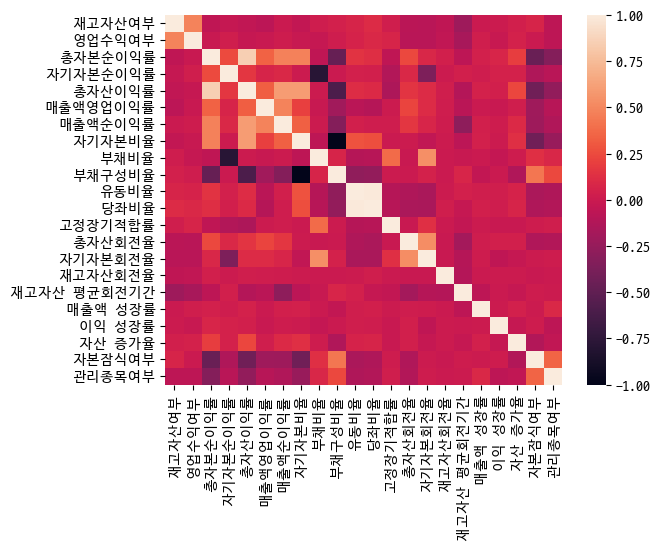

In [749]:
# 상관관계 확인
sns.heatmap(model_df.corr())

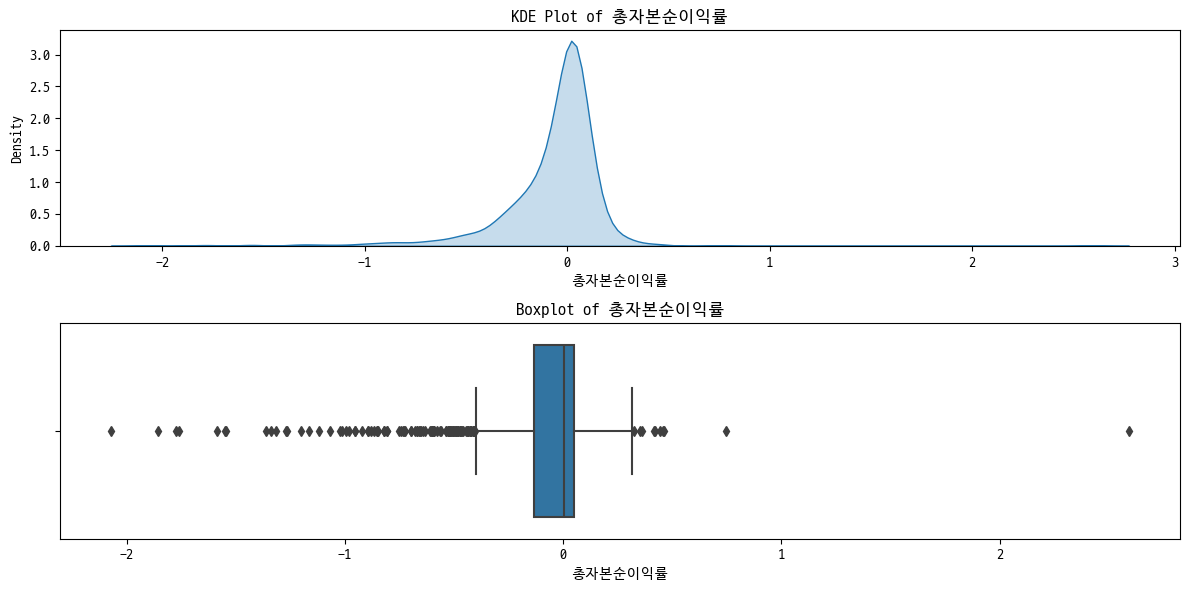

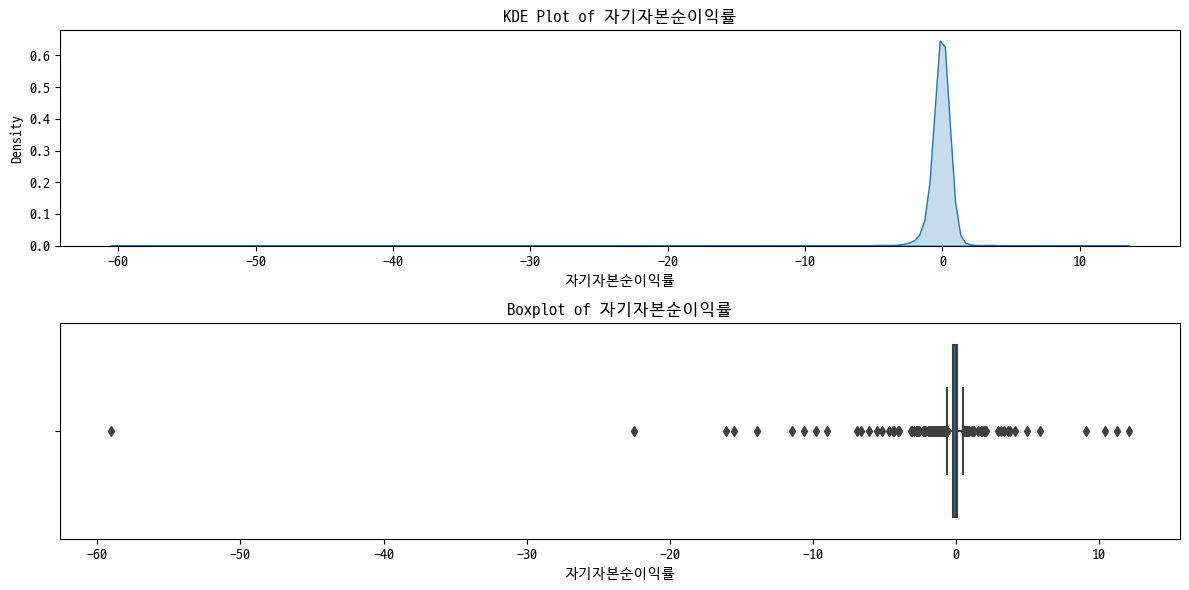

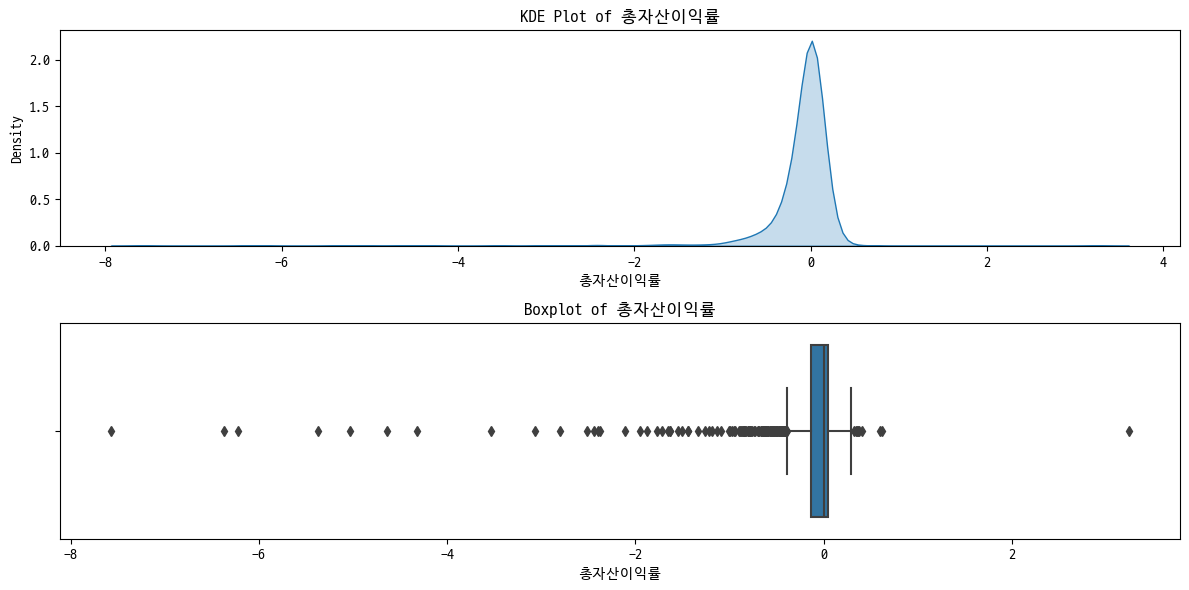

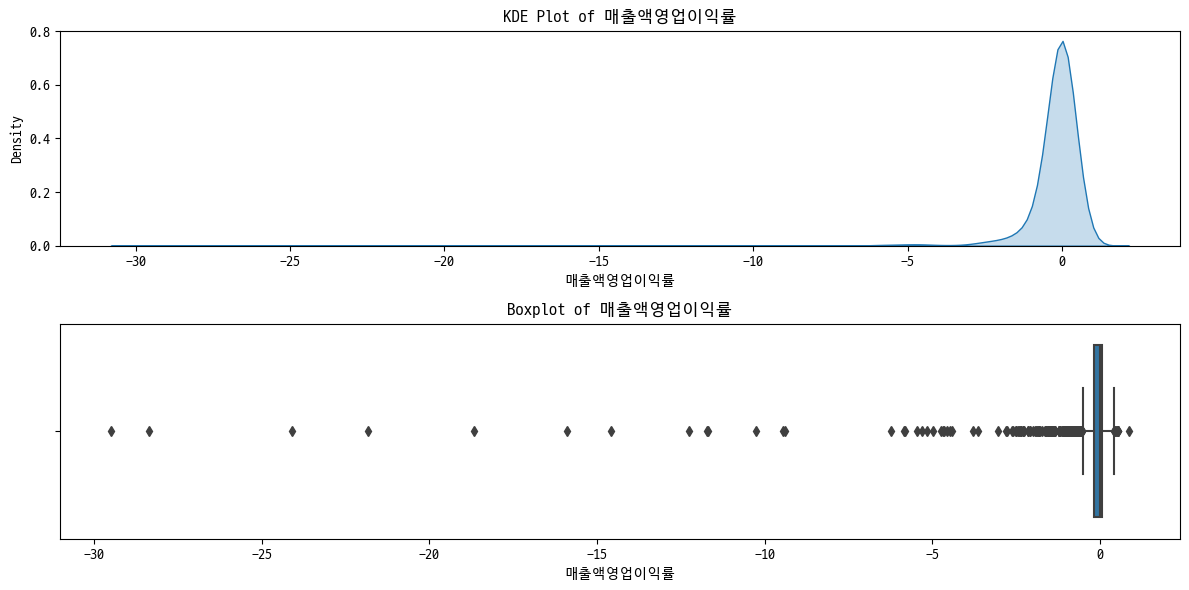

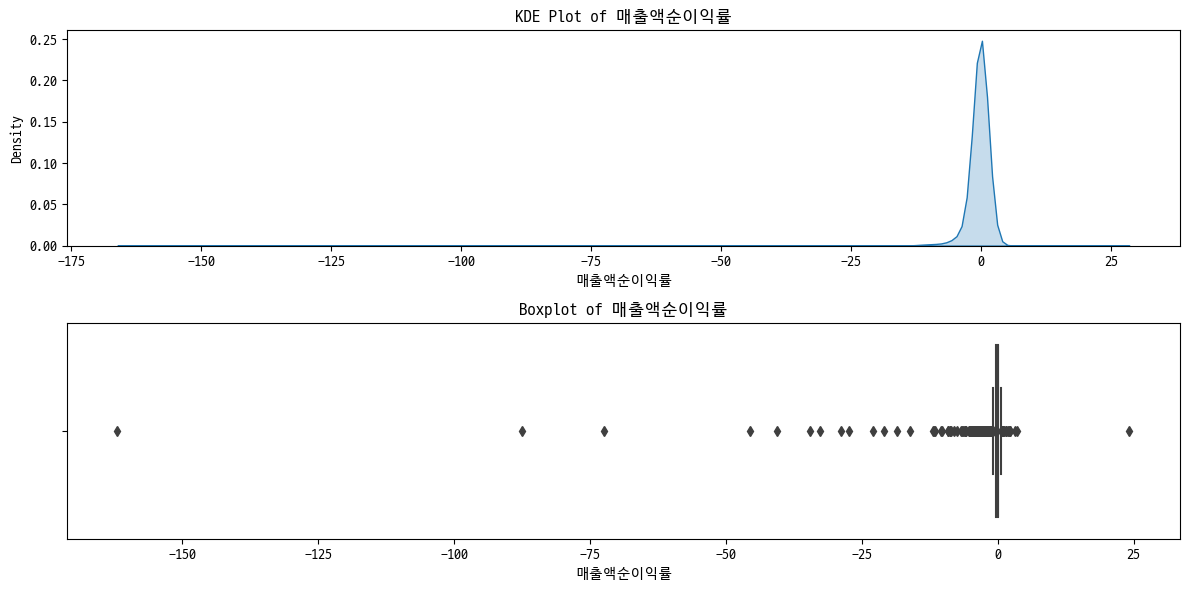

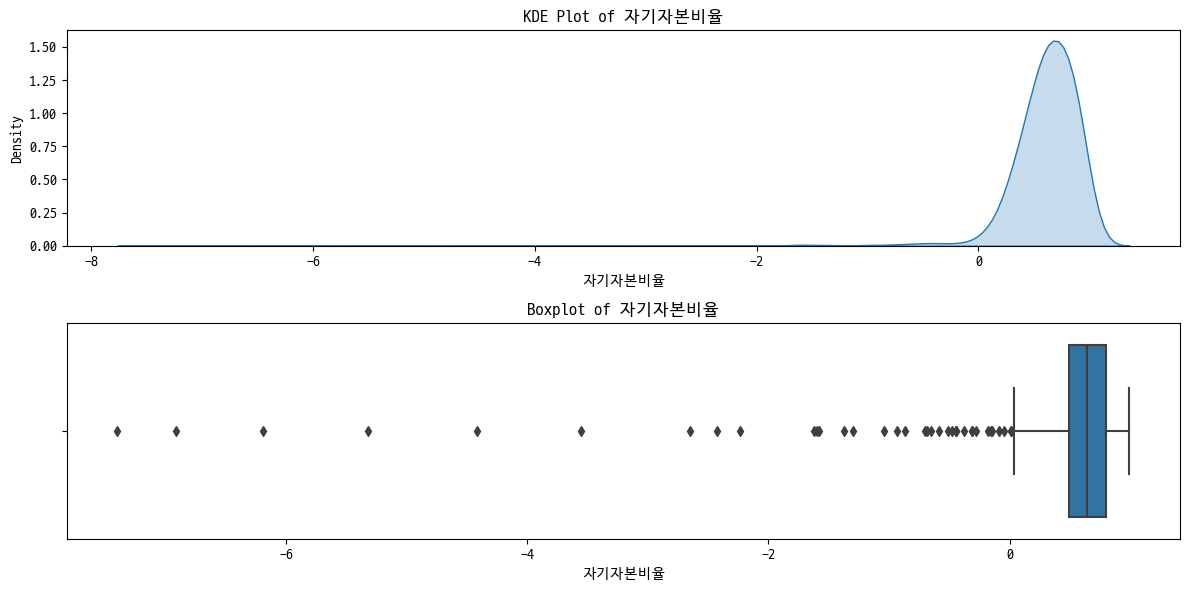

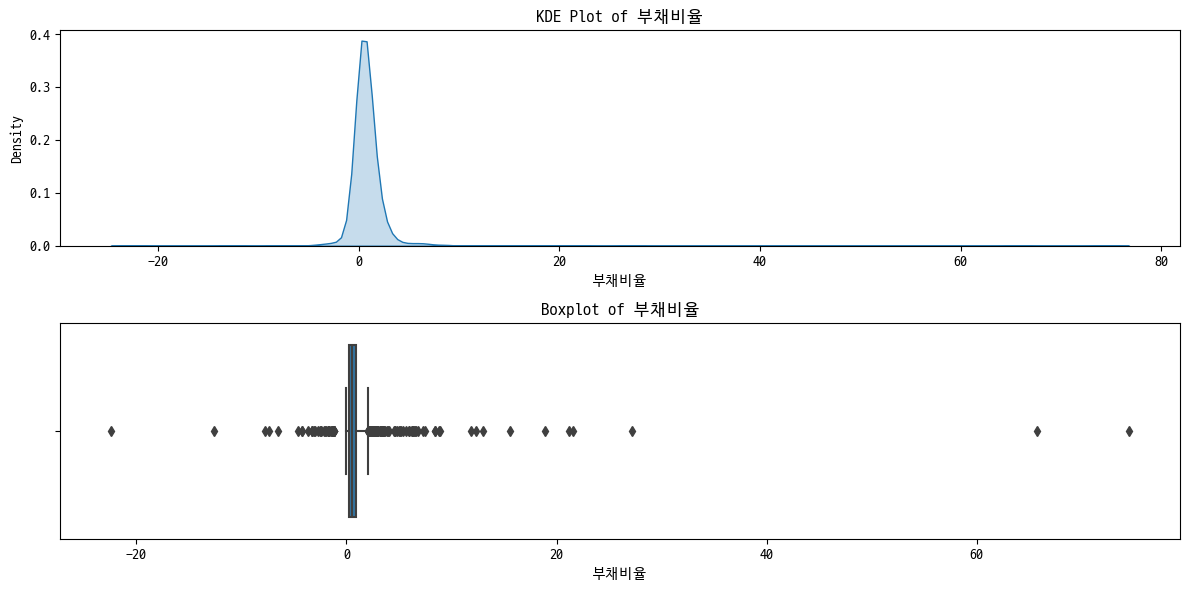

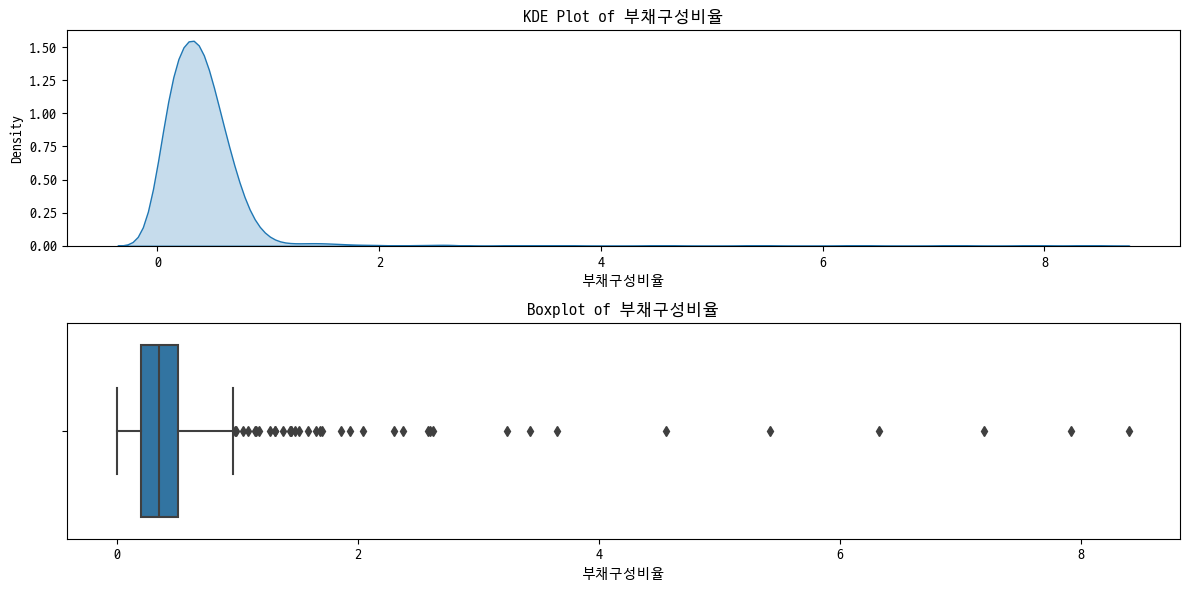

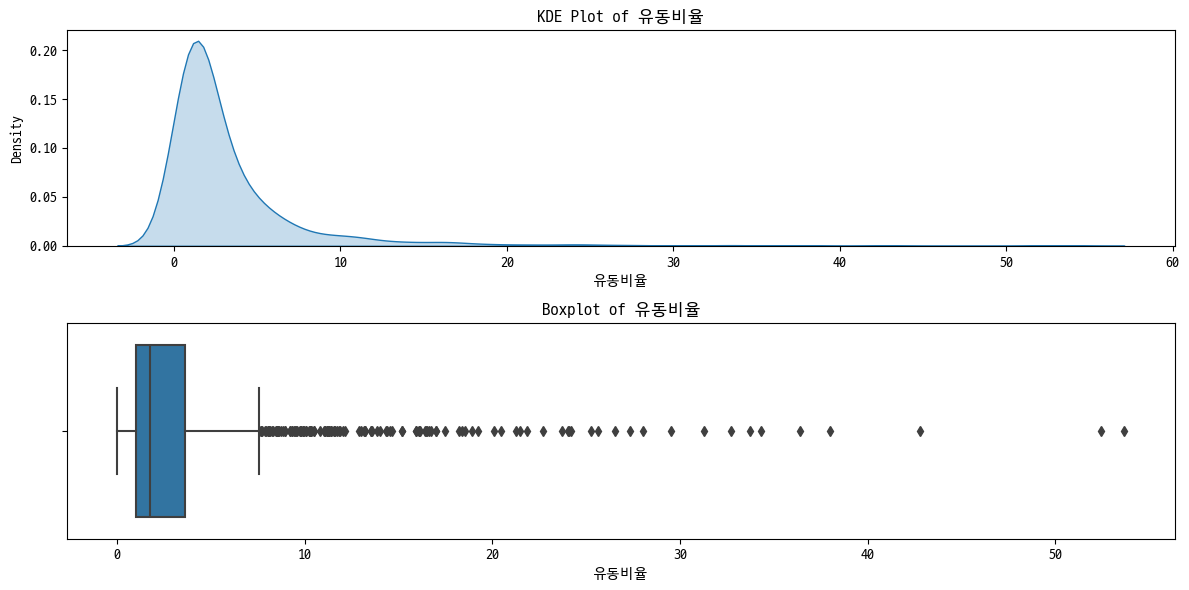

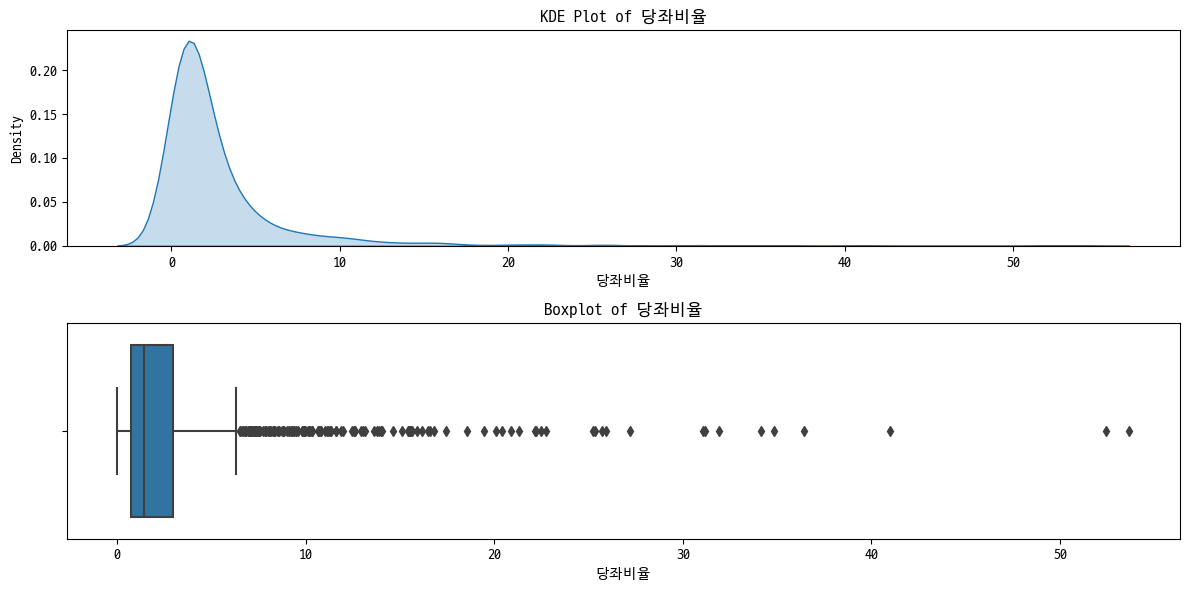

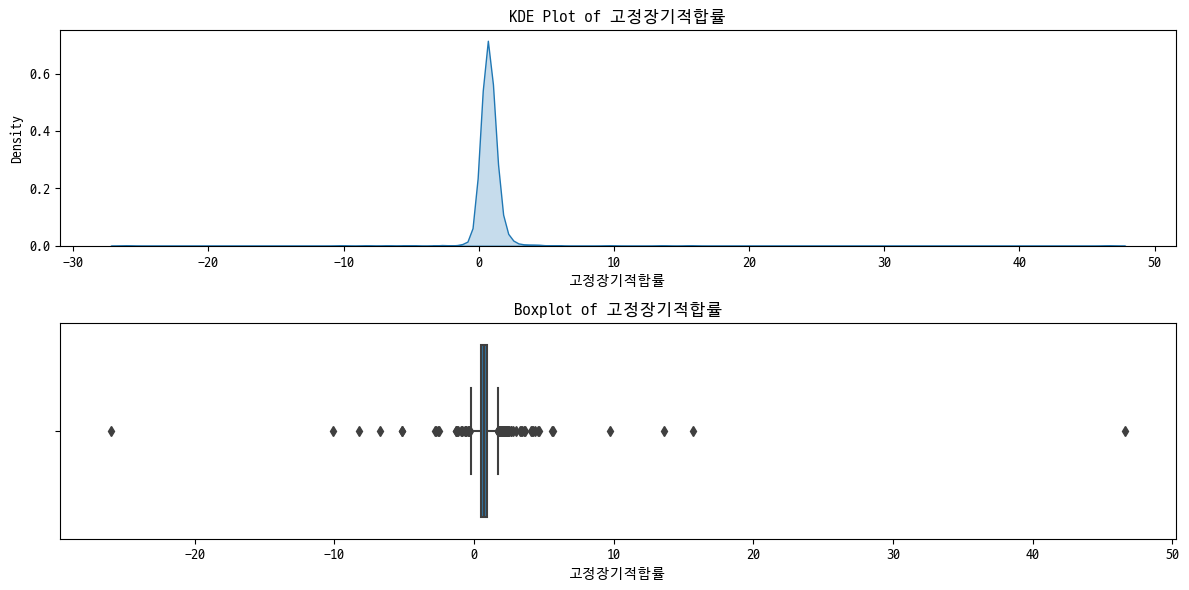

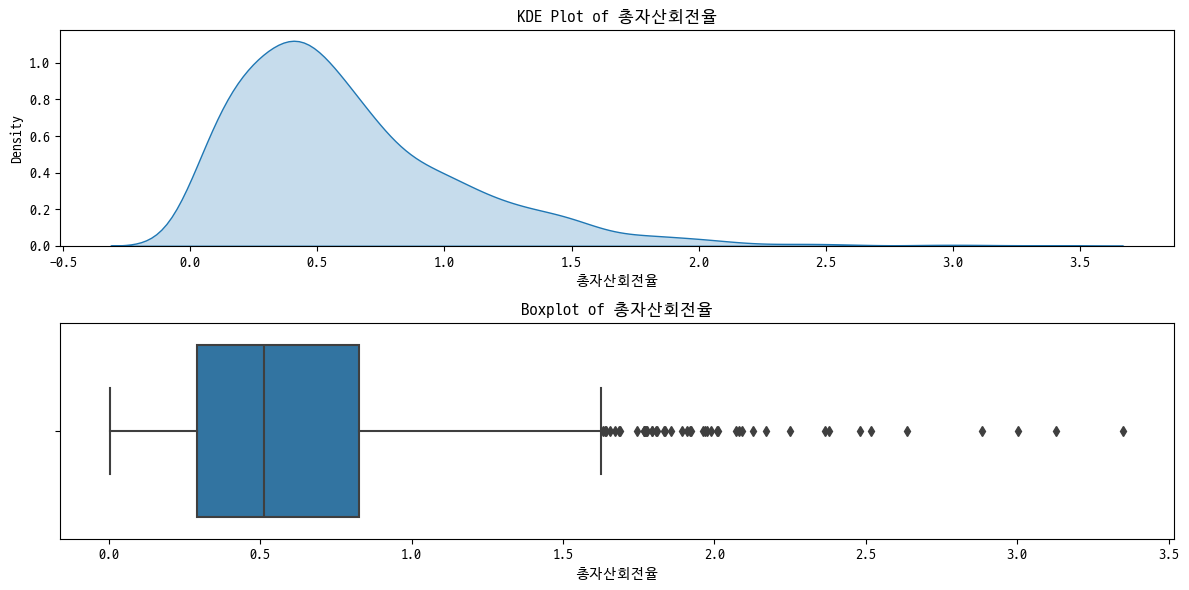

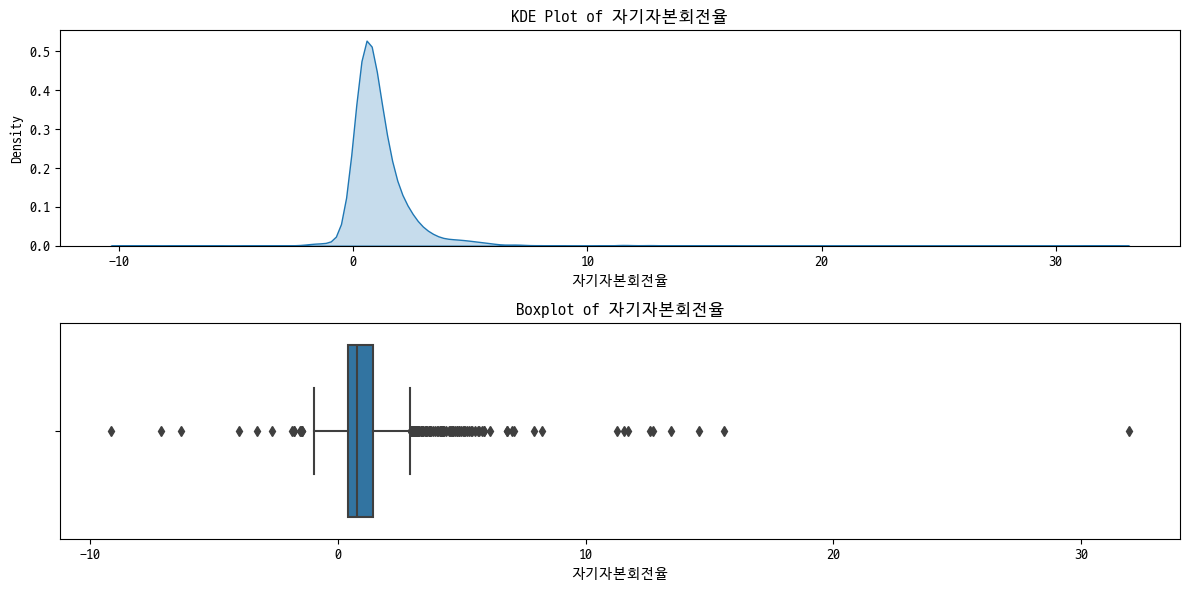

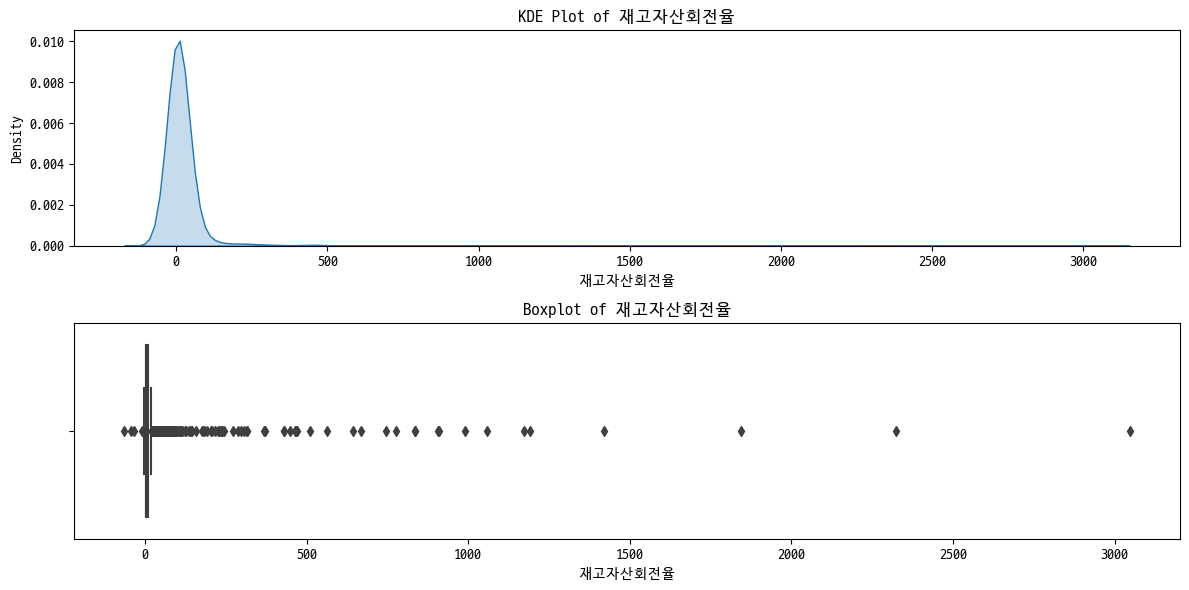

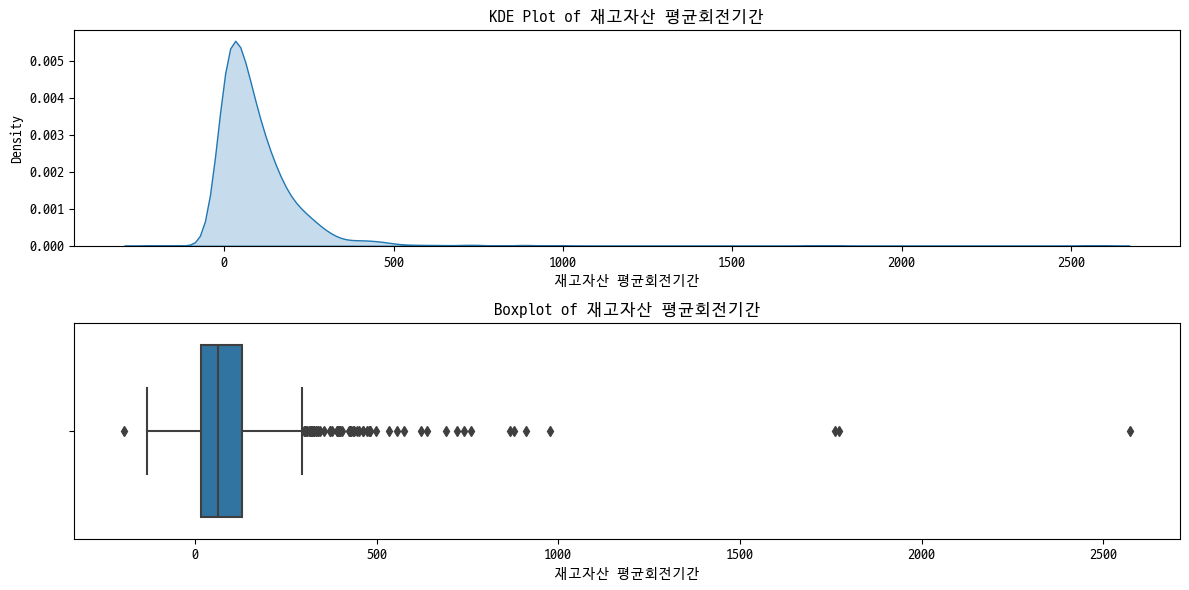

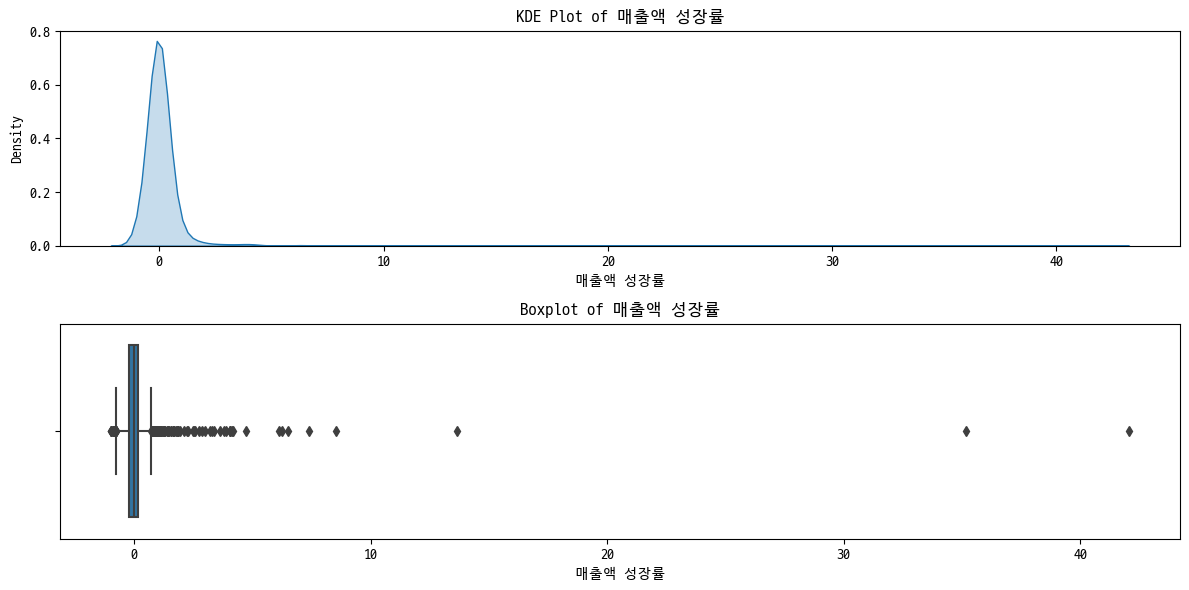

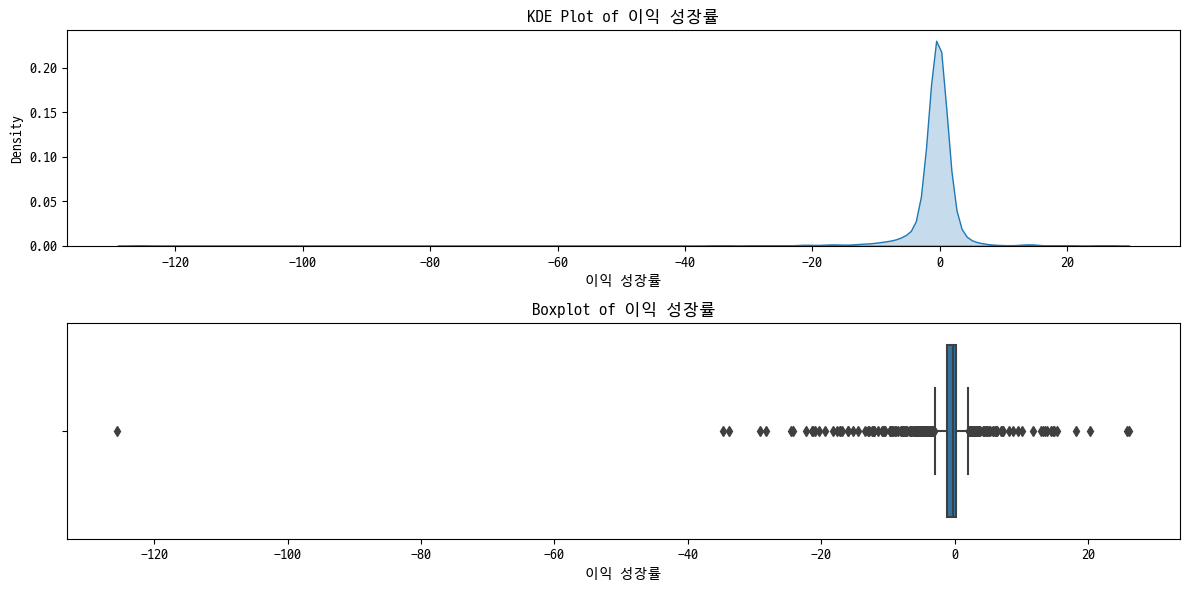

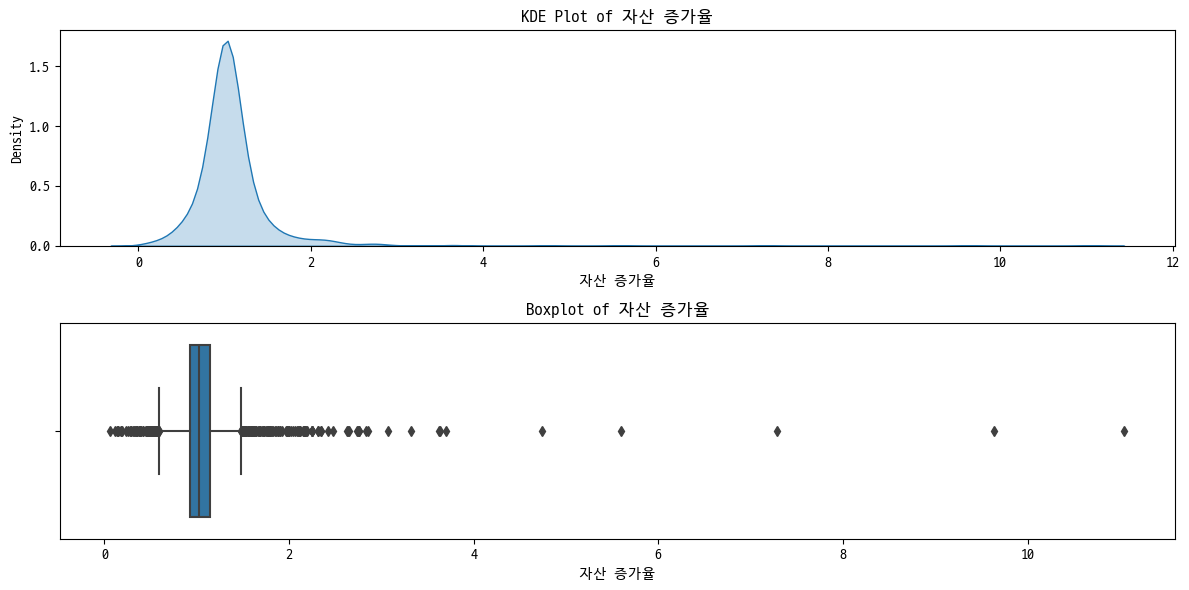

In [765]:
# 히스토그램, 박스플롯 그려주는 함수
def plot_histogram_boxplot(df, column):
    plt.figure(figsize=(12, 6))
    
    # KDE 플롯
    plt.subplot(2, 1, 1)
    try:
        sns.kdeplot(df[column], shade=True)
        plt.title(f'KDE Plot of {column}')
    except Exception as e:
        print(f"Error plotting KDE plot for {column}: {e}")
    
    # 박스플롯
    plt.subplot(2, 1, 2)
    try:
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column}')
    except Exception as e:
        print(f"Error plotting boxplot for {column}: {e}")
    
    plt.tight_layout()
    plt.show()


# 수치형 변수 분포 확인
num_ft = ['총자본순이익률', '자기자본순이익률', '총자산이익률', '매출액영업이익률',
       '매출액순이익률', '자기자본비율', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율']


for i in num_ft:
    plot_histogram_boxplot(model_df, i)

In [768]:
# 영업 수익이 존재하는 기업은 제외
model_df = model_df[model_df['영업수익여부']==0]
model_df.reset_index(drop=True, inplace=True)

In [769]:
# 부채구성비율과 자기자본비율의 상관관계가 1 : 둘 중 하나 제거
model_df.drop(columns=['자기자본비율'], inplace=True)
model_df.reset_index(drop=True, inplace=True)

In [770]:
# Target 값 분리
target = model_df['관리종목여부']
model_df.drop(columns=['관리종목여부'],inplace=True)

In [771]:
# train, test 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(model_df, target, test_size=0.2, stratify=target,random_state=1004)

In [772]:
# StandardScaler 스케일링(수치형 변수)
ss = StandardScaler()
x_train[['총자본순이익률', '자기자본순이익률', '매출액영업이익률', '총자산이익률',
       '매출액순이익률', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율']] = ss.fit_transform(x_train[['총자본순이익률', '자기자본순이익률', '매출액영업이익률', '총자산이익률',
       '매출액순이익률', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율']])
x_test[['총자본순이익률', '자기자본순이익률', '매출액영업이익률', '총자산이익률',
       '매출액순이익률', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율']] = ss.transform(x_test[['총자본순이익률', '자기자본순이익률', '매출액영업이익률', '총자산이익률',
       '매출액순이익률', '부채비율', '부채구성비율', '유동비율', '당좌비율', '고정장기적합률',
       '총자산회전율', '자기자본회전율', '재고자산회전율', '재고자산 평균회전기간', '매출액 성장률', '이익 성장률',
       '자산 증가율']])

## 로지스틱회귀

In [235]:
# 하이퍼파라미터 범위
param_distributions = {
    'C': loguniform(1e-4, 10.0), 
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'penalty': ['l1', 'l2', 'none']  
}

# 로지스틱 회귀 모델 초기화
model = LogisticRegression(random_state=1004, max_iter=1000)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=100,  
    cv=3, 
    scoring='f1',  
    random_state=42,
    n_jobs=-1  
)

# 하이퍼파라미터 최적화 수행
random_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-validation Accuracy: {best_score:.4f}")

Best Parameters: {'C': 1.7790693962001112, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation Accuracy: 0.5366


In [288]:
# 모델 생성
ls_model = LogisticRegression(C=1.7790693962001112, solver='liblinear', penalty='l2', random_state=1004, max_iter=1000)

In [290]:
ls_model.fit(x_train, y_train)

LogisticRegression(C=1.7790693962001112, max_iter=1000, random_state=1004,
                   solver='liblinear')

In [292]:
# 임곗값을 0.4로 설정해서 예측
y_pred_proba = ls_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

In [293]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.6424242424242425
accuracy_score : 0.7748091603053435
recall_score : 0.5638297872340425
precision_score:  0.7464788732394366
roc_auc_score:  0.7283434650455928
confusion_matrix 
 [[150  18]
 [ 41  53]]


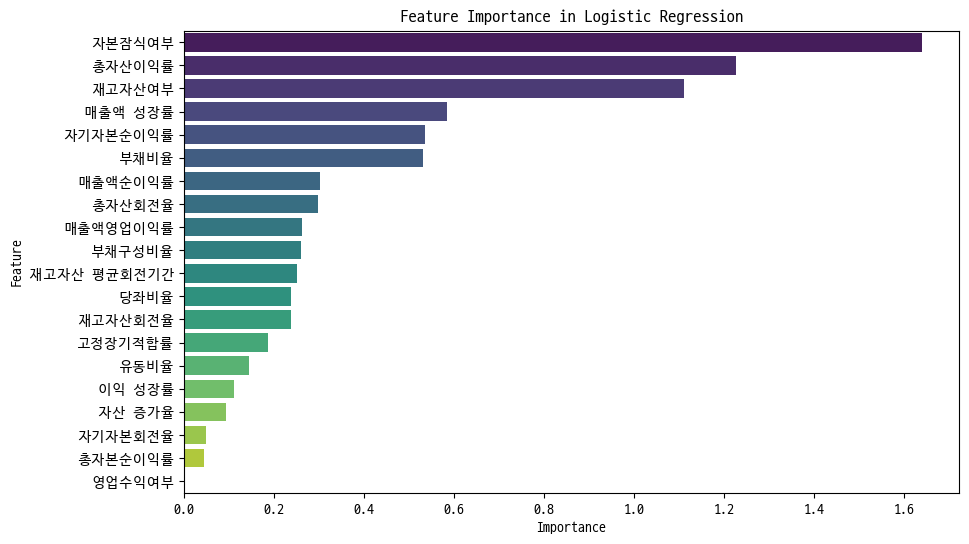

In [294]:
# 변수 중요도 계산
feature_names = x_train.columns
coefficients = ls_model.coef_

# 클래스별 변수 중요도를 절대값 기준으로 평균
importance = np.abs(coefficients).mean(axis=0)
importance_indices = np.argsort(importance)[::-1]

# 변수 이름과 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[importance_indices],
    'Importance': importance[importance_indices]
})

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 의사결정나무

In [259]:
# 하이퍼파라미터 검색 공간 정의
param_distributions = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy']
}

# 의사결정나무 모델 초기화
model = DecisionTreeClassifier(random_state=1004)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=100,  # 시도할 하이퍼파라미터 조합의 수
    cv=3,  # 교차 검증 분할 수
    scoring='accuracy',  # 평가 메트릭
    random_state=42,
    n_jobs=-1  # 병렬 처리
)

# 하이퍼파라미터 최적화 수행
random_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-validation Accuracy: {best_score:.4f}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 18}
Best Cross-validation Accuracy: 0.7404


In [283]:
dt_model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 11, min_samples_split=18, random_state=1004)

In [284]:
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=11,
                       min_samples_split=18, random_state=1004)

In [285]:
y_pred = dt_model.predict(x_test)

In [286]:
y_pred_proba = dt_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

In [287]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.6822429906542056
accuracy_score : 0.7404580152671756
recall_score : 0.776595744680851
precision_score:  0.6083333333333333
roc_auc_score:  0.7484169199594732
confusion_matrix 
 [[121  47]
 [ 21  73]]


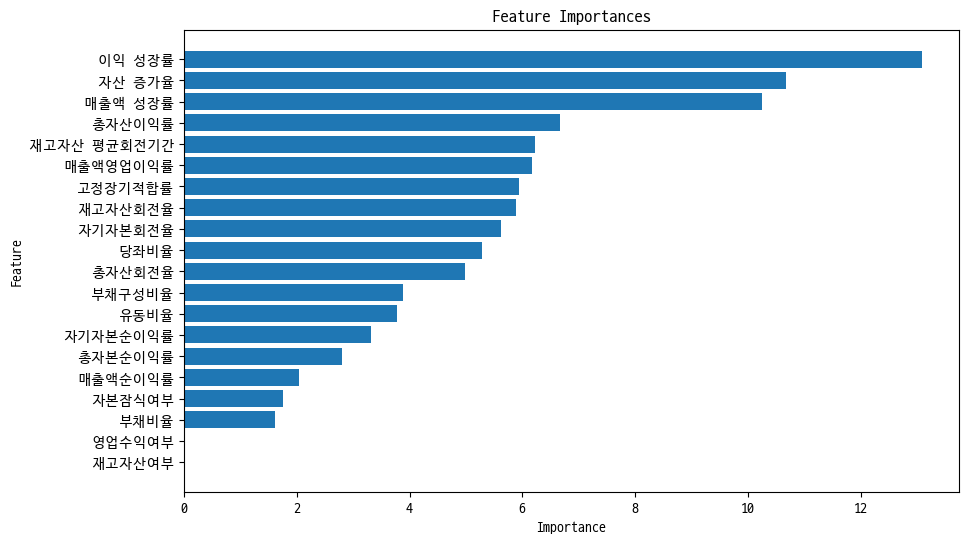

In [297]:
# 변수 중요도 가져오기
importances = dt_model.feature_importances_
feature_names = x_train.columns


# 변수 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


# 중요도 순서로 정렬
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위에 오도록 y축 반전
plt.show()

## 랜덤포레스트

In [311]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'bootstrap': True,
        'n_jobs': -1,
        'random_state': 1004,
        'class_weight': 'balanced'  # 클래스 불균형 고려
    }
    # 모델 초기화
    model = RandomForestClassifier(criterion='log_loss',**params)
    
    # 모델 학습
    model.fit(x_train, y_train)
    
    # 검증 세트에서 성능 측정
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)
    
    return f1

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 하이퍼파라미터 출력
best_params = study.best_params
print(best_params)

[I 2024-07-10 09:43:54,273] A new study created in memory with name: no-name-8e9d0e8b-5bd8-4372-a2f8-5868d243af53
[I 2024-07-10 09:44:00,946] Trial 0 finished with value: 0.6834170854271358 and parameters: {'n_estimators': 1166, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.7592659004616016}. Best is trial 0 with value: 0.6834170854271358.
[I 2024-07-10 09:44:05,336] Trial 1 finished with value: 0.7010309278350516 and parameters: {'n_estimators': 1093, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.33624280056566824}. Best is trial 1 with value: 0.7010309278350516.
[I 2024-07-10 09:44:16,100] Trial 2 finished with value: 0.6938775510204082 and parameters: {'n_estimators': 1970, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5485373693108612}. Best is trial 1 with value: 0.7010309278350516.
[I 2024-07-10 09:44:21,980] Trial 3 finished with value: 0.6770833333333333 and parameters: {'n_

{'n_estimators': 1429, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.8520902384413765}


In [313]:
rf_params = {'n_estimators': 1429, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.8520902384413765}

In [315]:
rf_model = RandomForestClassifier(criterion='log_loss',class_weight='balanced' , **rf_params, random_state=1004)

In [316]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=5, max_features=0.8520902384413765,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1429, random_state=1004)

In [317]:
y_pred = rf_model.predict(x_test)

In [334]:
y_pred_proba = rf_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

In [335]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.7148936170212766
accuracy_score : 0.7442748091603053
recall_score : 0.8936170212765957
precision_score:  0.5957446808510638
roc_auc_score:  0.7771656534954408
confusion_matrix 
 [[111  57]
 [ 10  84]]


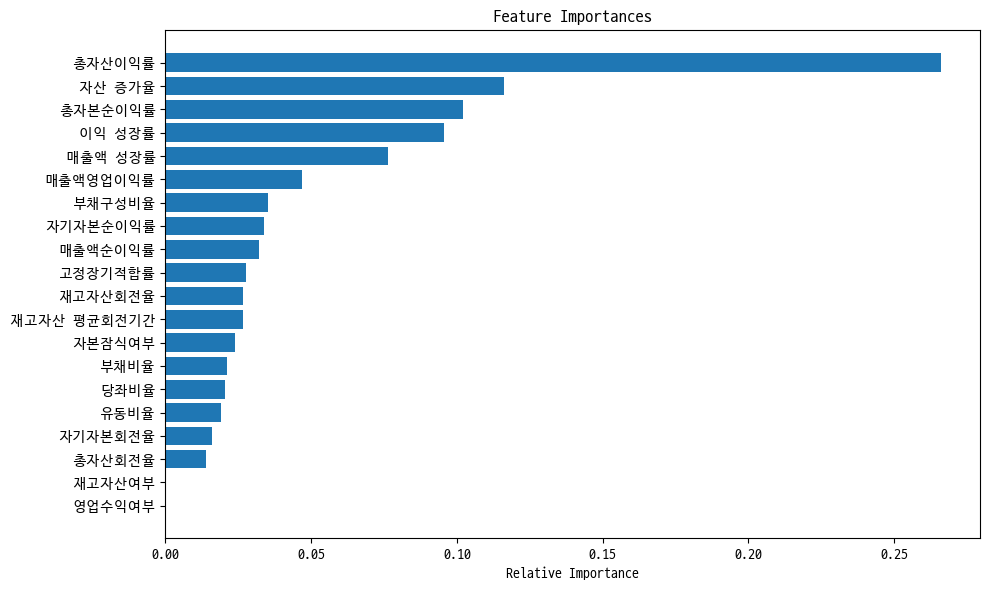

In [338]:
# Extract feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = x_train.columns

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

## ExtraTrees 모델

In [322]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 5),
        'max_features': trial.suggest_uniform('max_features', 0.1, 1.0),
        'bootstrap': False,  # ExtraTrees에서는 부트스트랩 샘플링을 사용하지 않음
        'n_jobs': -1,
        'random_state': 1004,
        'class_weight': 'balanced'  # 클래스 불균형 고려
    }
    
    # 모델 초기화
    model = ExtraTreesClassifier(**params)
    
    # 모델 학습
    model.fit(x_train, y_train)
    
    # 검증 세트에서 성능 측정
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)
    
    return f1

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 하이퍼파라미터 출력
best_params = study.best_params
print(best_params)


[I 2024-07-10 10:08:39,531] A new study created in memory with name: no-name-46df764a-5fde-4998-839f-4aaa8b15eda4
[I 2024-07-10 10:08:48,957] Trial 0 finished with value: 0.6559139784946236 and parameters: {'n_estimators': 2292, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 0.3500920217260972}. Best is trial 0 with value: 0.6559139784946236.
[I 2024-07-10 10:09:04,231] Trial 1 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 3854, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.14429353482602947}. Best is trial 0 with value: 0.6559139784946236.
[I 2024-07-10 10:09:26,105] Trial 2 finished with value: 0.6153846153846153 and parameters: {'n_estimators': 4220, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.8082444611659456}. Best is trial 0 with value: 0.6559139784946236.
[I 2024-07-10 10:09:44,965] Trial 3 finished with value: 0.6235294117647059 and parameters: {'n

KeyboardInterrupt: 

In [323]:
et_params = {'n_estimators': 3506, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.9149589747641587}

In [325]:
et_model = ExtraTreesClassifier(**et_params, class_weight= 'balanced', random_state=1004)

In [326]:
et_model.fit(x_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=7,
                     max_features=0.9149589747641587, min_samples_leaf=5,
                     min_samples_split=4, n_estimators=3506, random_state=1004)

In [327]:
y_pred = et_model.predict(x_test)

In [330]:
y_pred_proba = et_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

In [331]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.7123287671232877
accuracy_score : 0.7595419847328244
recall_score : 0.8297872340425532
precision_score:  0.624
roc_auc_score:  0.7750126646403243
confusion_matrix 
 [[121  47]
 [ 16  78]]


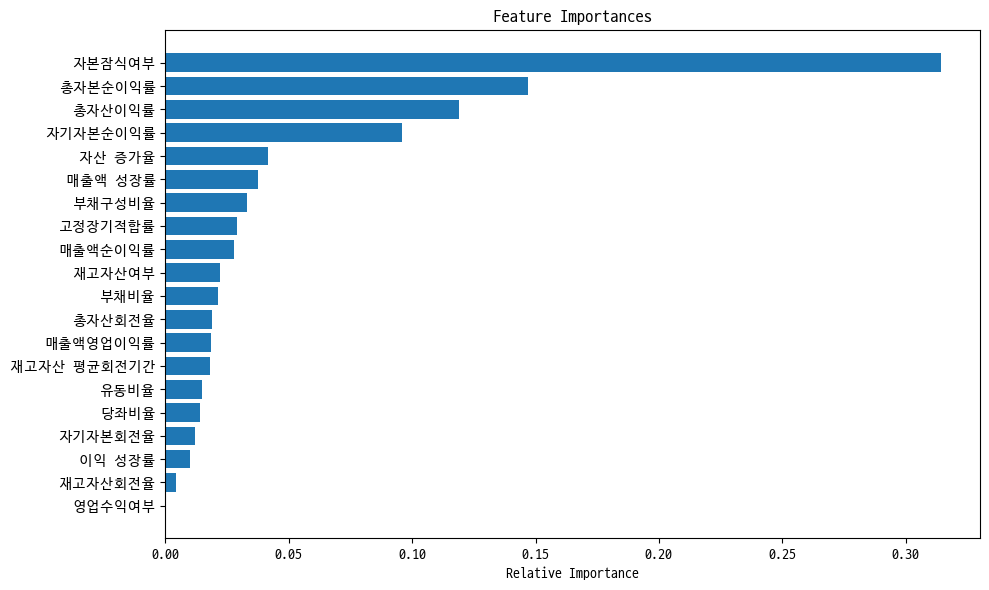

In [339]:
# Extract feature importances
importances = et_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = x_train.columns

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

## Catboost

In [188]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'thread_count': -1,
        'verbose': False
    }

    # 모델 초기화
    model = CatBoostClassifier(loss_function='Logloss', class_weights=[1,5],**params, random_state=1004)

    # 모델 학습
    model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=100, verbose=False)

    # 검증 세트에서 성능 측정
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)

    return f1

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 하이퍼파라미터 출력
best_params = study.best_params
print(best_params)

[I 2024-07-09 17:42:39,879] A new study created in memory with name: no-name-c3261be8-af06-4c78-8fd1-d78d9811ba6f
[I 2024-07-09 17:42:40,564] Trial 0 finished with value: 0.6696035242290749 and parameters: {'iterations': 687, 'learning_rate': 0.08492730234568145, 'depth': 7, 'l2_leaf_reg': 0.00025712561989338286, 'random_strength': 0.0021700177178414896, 'bagging_temperature': 0.9607948184156252, 'border_count': 138}. Best is trial 0 with value: 0.6696035242290749.
[I 2024-07-09 17:42:41,552] Trial 1 finished with value: 0.7107438016528925 and parameters: {'iterations': 727, 'learning_rate': 0.025244245120485485, 'depth': 5, 'l2_leaf_reg': 4.2491942591025245, 'random_strength': 0.005354844299175293, 'bagging_temperature': 0.4264735755994895, 'border_count': 214}. Best is trial 1 with value: 0.7107438016528925.
[I 2024-07-09 17:42:42,895] Trial 2 finished with value: 0.675 and parameters: {'iterations': 798, 'learning_rate': 0.06999430184980862, 'depth': 8, 'l2_leaf_reg': 0.476276358515

{'iterations': 746, 'learning_rate': 0.06479920262320031, 'depth': 10, 'l2_leaf_reg': 2.8956112833714402, 'random_strength': 0.001902622790051195, 'bagging_temperature': 0.9943762669497263, 'border_count': 144}


In [189]:
cat_params = {'iterations': 746, 'learning_rate': 0.06479920262320031, 'depth': 10, 'l2_leaf_reg': 2.8956112833714402, 'random_strength': 0.001902622790051195, 'bagging_temperature': 0.9943762669497263, 'border_count': 144}

In [203]:
cat_model = CatBoostClassifier(loss_function='Logloss', class_weights=[1,5], **cat_params, random_state=1004)

In [204]:
cat_model.fit(x_train,y_train)

0:	learn: 0.6450679	total: 41.2ms	remaining: 30.7s
1:	learn: 0.6034134	total: 83.3ms	remaining: 31s
2:	learn: 0.5680680	total: 127ms	remaining: 31.4s
3:	learn: 0.5366689	total: 164ms	remaining: 30.4s
4:	learn: 0.5069834	total: 196ms	remaining: 29.1s
5:	learn: 0.4818934	total: 232ms	remaining: 28.7s
6:	learn: 0.4589280	total: 266ms	remaining: 28.1s
7:	learn: 0.4384545	total: 302ms	remaining: 27.8s
8:	learn: 0.4209300	total: 336ms	remaining: 27.5s
9:	learn: 0.4064657	total: 372ms	remaining: 27.4s
10:	learn: 0.3908477	total: 404ms	remaining: 27s
11:	learn: 0.3765213	total: 437ms	remaining: 26.7s
12:	learn: 0.3621206	total: 468ms	remaining: 26.4s
13:	learn: 0.3524316	total: 499ms	remaining: 26.1s
14:	learn: 0.3406566	total: 533ms	remaining: 26s
15:	learn: 0.3299009	total: 565ms	remaining: 25.8s
16:	learn: 0.3201881	total: 596ms	remaining: 25.6s
17:	learn: 0.3105121	total: 633ms	remaining: 25.6s
18:	learn: 0.3006355	total: 664ms	remaining: 25.4s
19:	learn: 0.2943567	total: 701ms	remaining: 

In [205]:
pred = cat_model.predict(x_test)
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
      dtype=int64)

In [207]:
y_pred_proba = cat_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

In [208]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.7227722772277227
accuracy_score : 0.7862595419847328
recall_score : 0.776595744680851
precision_score:  0.6759259259259259
roc_auc_score:  0.7841312056737588
confusion_matrix 
 [[133  35]
 [ 21  73]]


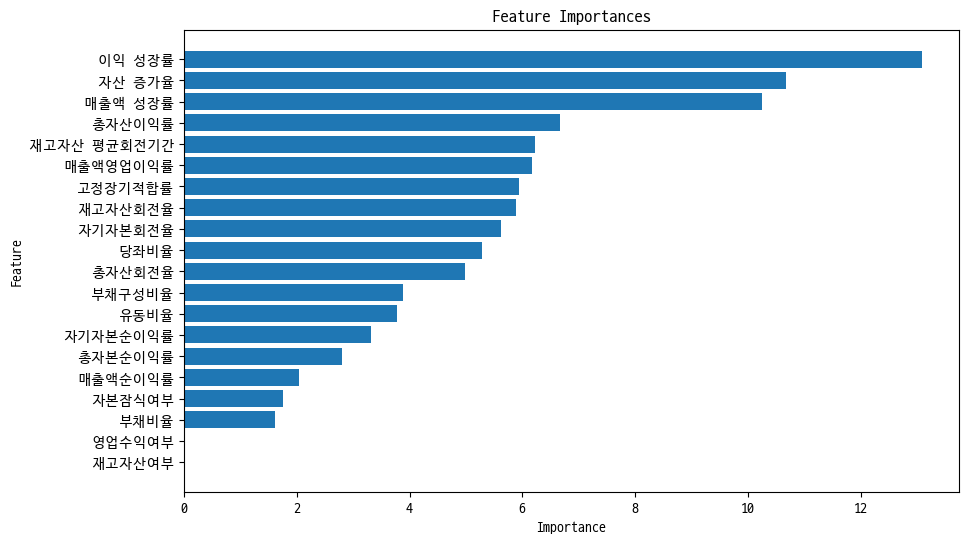

In [209]:
# 변수 중요도 계산
feature_importances = cat_model.get_feature_importance()
feature_names = x_train.columns


# 변수 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


# 중요도 순서로 정렬
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위에 오도록 y축 반전
plt.show()

## XGB

In [773]:
# 클래스 불균형 비율 계산
ratio = target.value_counts()[0] / target.value_counts()[1]

def objective(trial):
    params = {'scale_pos_weight': ratio,
        'objective': 'binary:logistic',  # 이진 분류 문제의 경우
        'eval_metric': 'logloss',  # 평가 지표: Log Loss
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'random_state': 1004,
        'use_label_encoder': False  # XGBoost에서 Label Encoder 사용 안 함
    }

    # XGBoost 모델 초기화
    model = xgb.XGBClassifier(**params, n_jobs=-1)

    # 모델 학습
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

    # 검증 세트에서 성능 측정: F1 점수
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)

    return f1

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적화된 하이퍼파라미터 출력
best_params = study.best_params
print(best_params)

[I 2024-07-11 17:31:48,731] A new study created in memory with name: no-name-36ef1f09-01c8-420c-aada-a400bb1e68d5
[I 2024-07-11 17:31:49,319] Trial 0 finished with value: 0.7135678391959798 and parameters: {'learning_rate': 0.03880850317316177, 'max_depth': 6, 'min_child_weight': 5.508081707516811, 'subsample': 0.7618567344905183, 'colsample_bytree': 0.6940069905185924, 'gamma': 1.9047607511429916e-06}. Best is trial 0 with value: 0.7135678391959798.
[I 2024-07-11 17:31:49,866] Trial 1 finished with value: 0.7244897959183673 and parameters: {'learning_rate': 0.019670379144477716, 'max_depth': 8, 'min_child_weight': 0.7387928813136296, 'subsample': 0.8288330860033235, 'colsample_bytree': 0.9480414504444121, 'gamma': 0.01938279738687631}. Best is trial 0 with value: 0.7135678391959798.
[I 2024-07-11 17:31:50,435] Trial 2 finished with value: 0.7244897959183673 and parameters: {'learning_rate': 0.012129184467627709, 'max_depth': 8, 'min_child_weight': 0.6078274120072538, 'subsample': 0.80

{'learning_rate': 0.010068825996312576, 'max_depth': 3, 'min_child_weight': 8.154792056002673, 'subsample': 0.556132657842801, 'colsample_bytree': 0.5133125079266736, 'gamma': 5.474328229895817e-06}


In [599]:
xgb_params = {'learning_rate': 0.0833518967951275, 'max_depth': 3, 'min_child_weight': 9.977163756183826, 'subsample': 0.7750925903712037, 'colsample_bytree': 0.8062086221490441, 'gamma': 5.1994434678901974e-05}

In [600]:
xgb_model = xgb.XGBClassifier(**xgb_params, random_state=1004)

In [776]:
# 샘플 가중치 설정
sample_weights = np.where(y_train == 1, 3, 1)

In [498]:
xgb_model.fit(x_train, y_train,sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6509541312512691, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.9179707753872226,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.020718829125659838,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.28846792290048523, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1004, ...)

In [780]:
y_pred_proba = xgb_model.predict_proba(x_test)[:, 1]
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

In [500]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.7190082644628099
accuracy_score : 0.7404580152671756
recall_score : 0.925531914893617
precision_score:  0.5878378378378378
roc_auc_score:  0.7812183383991894
confusion_matrix 
 [[107  61]
 [  7  87]]


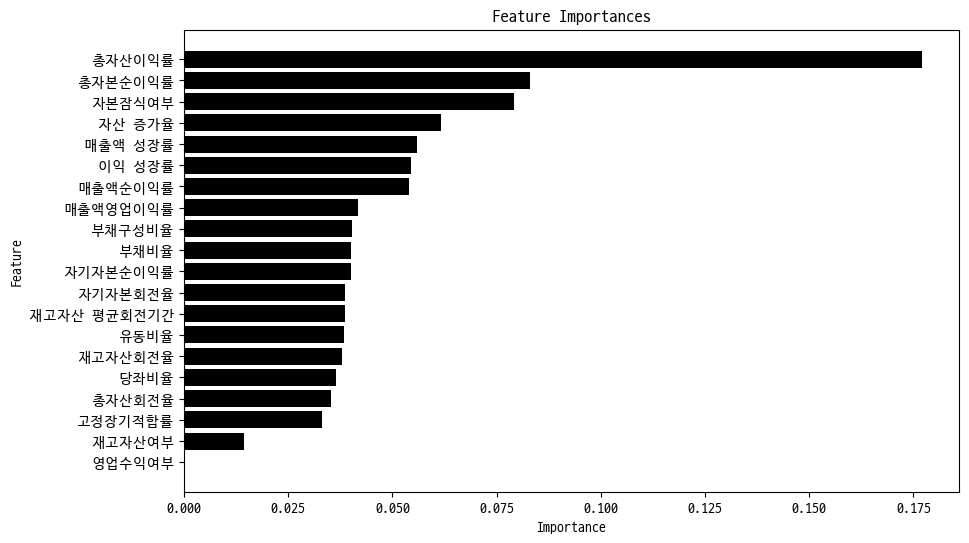

In [501]:
# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_
feature_names = x_train.columns

# 변수 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 중요도 순서로 정렬
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위에 오도록 y축 반전
plt.show()

## LGBM

In [156]:
# 클래스 불균형 비율 계산
ratio = target.value_counts()[0] / target.value_counts()[1]

def objective(trial):
    # 하이퍼파라미터 검색 공간 정의
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'scale_pos_weight': ratio
    }

    # LightGBM 모델 초기화
    model = lgb.LGBMClassifier(**params, random_state=1004)

    # 모델 학습
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)])

    # 검증 세트에서 성능 측정: F1 점수
    preds = model.predict(x_test)
    f1 = f1_score(y_test, preds)

    return f1

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 하이퍼파라미터 출력
best_params = study.best_params
print(best_params)

[I 2024-07-09 17:40:07,996] A new study created in memory with name: no-name-3b40a26b-c4b3-423a-9952-59eb54abdc46
[I 2024-07-09 17:40:08,189] Trial 0 finished with value: 0.7253886010362693 and parameters: {'learning_rate': 0.07059086073498588, 'max_depth': 9, 'min_child_samples': 36, 'subsample': 0.6207692457328668, 'colsample_bytree': 0.7567779989949244, 'reg_alpha': 0.15370374371161294, 'reg_lambda': 0.00026226248953637116}. Best is trial 0 with value: 0.7253886010362693.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:Boost

[I 2024-07-09 17:40:08,279] Trial 1 finished with value: 0.7093596059113301 and parameters: {'learning_rate': 0.04839323570818823, 'max_depth': 8, 'min_child_samples': 79, 'subsample': 0.9044277516224466, 'colsample_bytree': 0.5060005100843912, 'reg_alpha': 0.1367291425201424, 'reg_lambda': 2.991931822163025e-08}. Best is trial 0 with value: 0.7253886010362693.
[I 2024-07-09 17:40:08,385] Trial 2 finished with value: 0.7192118226600985 and parameters: {'learning_rate': 0.047979058559439625, 'max_depth': 8, 'min_child_samples': 59, 'subsample': 0.8852536345360038, 'colsample_bytree': 0.8947365689993028, 'reg_alpha': 8.654077817796608e-05, 'reg_lambda': 0.0002921785963031371}. Best is trial 0 with value: 0.7253886010362693.
[I 2024-07-09 17:40:08,449] Trial 3 finished with value: 0.6934673366834171 and parameters: {'learning_rate': 0.09037581551433639, 'max_depth': 5, 'min_child_samples': 75, 'subsample': 0.6293611764141364, 'colsample_bytree': 0.6387702663873607, 'reg_alpha': 2.36621226

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:08,516] Trial 4 finished with value: 0.689655172413793 and parameters: {'learning_rate': 0.057377259715037744, 'max_depth': 3, 'min_child_samples': 48, 'subsample': 0.8878026605777646, 'colsample_bytree': 0.9203282364437485, 'reg_alpha': 0.1673205194546106, 'reg_lambda': 4.557813426982478e-08}. Best is trial 0 with value: 0.7253886010362693.
[I 2024-07-09 17:40:08,600] Trial 5 finished with value: 0.7135678391959798 and parameters: {'learning_rate': 0.07879856314517741, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.6021103842748792, 'colsample_bytree': 0.6382261468306564, 'reg_alpha': 0.3907825093871508, 'reg_lambda': 1.8677649035618007}. Best is trial 0 with value: 0.7253886010362693.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Info] Start training from score -0.583022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-07-09 17:40:08,707] Trial 6 finished with value: 0.7439613526570049 and parameters: {'learning_rate': 0.026152852341801227, 'max_depth': 10, 'min_child_samples': 56, 'subsample': 0.9681414176972197, 'colsample_bytree': 0.8844510832569381, 'reg_alpha': 0.00011890853168154087, 'reg_lambda': 0.006358353203873251}. Best is trial 6 with value: 0.7439613526570049.
[I 2024-07-09 17:40:08,812] Trial 7 finished with value: 0.72 and parameters: {'learning_rate': 0.013858299645840021, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.6154105042916214, 'colsample_bytree': 0.7039006992939573, 'reg_alpha': 0.006546114816154225, 'reg_lambda': 4.6532677399089853e-08}. Best is trial 6 with value: 0.7439613526570049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:08,926] Trial 8 finished with value: 0.6560846560846562 and parameters: {'learning_rate': 0.01359319495555101, 'max_depth': 10, 'min_child_samples': 17, 'subsample': 0.9562703363660572, 'colsample_bytree': 0.5862506256353202, 'reg_alpha': 4.612703887811585, 'reg_lambda': 6.626731732151545e-06}. Best is trial 6 with value: 0.7439613526570049.
[I 2024-07-09 17:40:09,008] Trial 9 finished with value: 0.7005076142131981 and parameters: {'learning_rate': 0.04352325510834893, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.9409554564909011, 'colsample_bytree': 0.6567834553211804, 'reg_alpha': 0.006706968918602432, 'reg_lambda': 4.237069346050952e-05}. Best is trial 6 with value: 0.7439613526570049.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:09,140] Trial 10 finished with value: 0.702439024390244 and parameters: {'learning_rate': 0.02433230221736327, 'max_depth': 10, 'min_child_samples': 98, 'subsample': 0.7593390359882726, 'colsample_bytree': 0.8271724418416713, 'reg_alpha': 1.0689970260147883e-05, 'reg_lambda': 0.022591764445161408}. Best is trial 6 with value: 0.7439613526570049.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:09,306] Trial 11 finished with value: 0.7035175879396984 and parameters: {'learning_rate': 0.025503910254383727, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.5179213236172875, 'colsample_bytree': 0.8001372541174245, 'reg_alpha': 1.1613636575237529e-06, 'reg_lambda': 0.0064252145052507365}. Best is trial 6 with value: 0.7439613526570049.
[I 2024-07-09 17:40:09,509] Trial 12 finished with value: 0.7474747474747475 and parameters: {'learning_rate': 0.01990106158420265, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.7534677619763983, 'colsample_bytree': 0.993772136976304, 'reg_alpha': 0.0019187846152844718, 'reg_lambda': 3.4394439464378885e-06}. Best is trial 12 with value: 0.7474747474747475.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:09,668] Trial 13 finished with value: 0.729064039408867 and parameters: {'learning_rate': 0.020188036902706086, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.7948739876074505, 'colsample_bytree': 0.9971735967914801, 'reg_alpha': 0.0013349106138448987, 'reg_lambda': 3.3319284187399334e-06}. Best is trial 12 with value: 0.7474747474747475.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:10,128] Trial 14 finished with value: 0.6777777777777778 and parameters: {'learning_rate': 0.010265644151463329, 'max_depth': 9, 'min_child_samples': 4, 'subsample': 0.999025030185428, 'colsample_bytree': 0.979372029431076, 'reg_alpha': 8.375611907578065e-05, 'reg_lambda': 1.8157643189358605}. Best is trial 12 with value: 0.7474747474747475.
[I 2024-07-09 17:40:10,270] Trial 15 finished with value: 0.7184466019417476 and parameters: {'learning_rate': 0.03626570024424197, 'max_depth': 7, 'min_child_samples': 69, 'subsample': 0.8270292514584259, 'colsample_bytree': 0.9054389764197196, 'reg_alpha': 1.243769905299524e-06, 'reg_lambda': 3.213868100376691e-06}. Best is trial 12 with value: 0.7474747474747475.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:10,512] Trial 16 finished with value: 0.7499999999999999 and parameters: {'learning_rate': 0.018444159673865253, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7084275715558657, 'colsample_bytree': 0.8494067043162017, 'reg_alpha': 0.0008913921522249594, 'reg_lambda': 0.004451950850990616}. Best is trial 16 with value: 0.7499999999999999.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:10,773] Trial 17 finished with value: 0.7225130890052357 and parameters: {'learning_rate': 0.017160681730962763, 'max_depth': 7, 'min_child_samples': 4, 'subsample': 0.6951750972830512, 'colsample_bytree': 0.8345814602422007, 'reg_alpha': 0.002316377355443477, 'reg_lambda': 4.6957717209516496e-07}. Best is trial 16 with value: 0.7499999999999999.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:11,023] Trial 18 finished with value: 0.7411167512690355 and parameters: {'learning_rate': 0.017364925487496644, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7126479251507793, 'colsample_bytree': 0.9549290858744296, 'reg_alpha': 6.1484304278299405e-06, 'reg_lambda': 0.2264474566963443}. Best is trial 16 with value: 0.7499999999999999.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:11,194] Trial 19 finished with value: 0.7384615384615384 and parameters: {'learning_rate': 0.031997798478845735, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.6914407272039668, 'colsample_bytree': 0.769375889955655, 'reg_alpha': 0.0006609228483677983, 'reg_lambda': 0.001331556812732875}. Best is trial 16 with value: 0.7499999999999999.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:11,438] Trial 20 finished with value: 0.7263157894736842 and parameters: {'learning_rate': 0.01134832480682062, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.8163665794187122, 'colsample_bytree': 0.8637924092364824, 'reg_alpha': 0.012013533047022726, 'reg_lambda': 3.274891274491586e-05}. Best is trial 16 with value: 0.7499999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

[I 2024-07-09 17:40:11,618] Trial 21 finished with value: 0.7562189054726367 and parameters: {'learning_rate': 0.025164897595438784, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.5309577116367643, 'colsample_bytree': 0.9382858076691077, 'reg_alpha': 0.00015015269323935567, 'reg_lambda': 0.0023208607986776324}. Best is trial 21 with value: 0.7562189054726367.
[I 2024-07-09 17:40:11,812] Trial 22 finished with value: 0.7208121827411168 and parameters: {'learning_rate': 0.01994470628812981, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.5085578219654482, 'colsample_bytree': 0.9545435248587247, 'reg_alpha': 2.337653611851754e-05, 'reg_lambda': 0.16807724864848766}. Best is trial 21 with value: 0.7562189054726367.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:11,985] Trial 23 finished with value: 0.7317073170731708 and parameters: {'learning_rate': 0.02169827002625744, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.5559019988497182, 'colsample_bytree': 0.9391047511166141, 'reg_alpha': 0.026772137316862187, 'reg_lambda': 0.0009036138016886673}. Best is trial 21 with value: 0.7562189054726367.
[I 2024-07-09 17:40:12,110] Trial 24 finished with value: 0.6772486772486772 and parameters: {'learning_rate': 0.015112598632847984, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.7420426143216277, 'colsample_bytree': 0.856870351867789, 'reg_alpha': 0.0004092304676315369, 'reg_lambda': 3.771672741224036e-05}. Best is trial 21 with value: 0.7562189054726367.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:12,306] Trial 25 finished with value: 0.7499999999999999 and parameters: {'learning_rate': 0.03079436244953994, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.6598090319534058, 'colsample_bytree': 0.9925089574746219, 'reg_alpha': 1.7383863515233808e-07, 'reg_lambda': 3.204088347405601e-07}. Best is trial 21 with value: 0.7562189054726367.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:12,487] Trial 26 finished with value: 0.7628865979381443 and parameters: {'learning_rate': 0.03163196740309905, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.6595763093005012, 'colsample_bytree': 0.926954478142559, 'reg_alpha': 1.2081815376068668e-08, 'reg_lambda': 3.8371683565376153e-07}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:12,712] Trial 27 finished with value: 0.731958762886598 and parameters: {'learning_rate': 0.03474139851365923, 'max_depth': 7, 'min_child_samples': 2, 'subsample': 0.5591523703326875, 'colsample_bytree': 0.8015122279874068, 'reg_alpha': 5.2045424804084105e-08, 'reg_lambda': 0.18032670979177629}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:12,851] Trial 28 finished with value: 0.7282051282051281 and parameters: {'learning_rate': 0.027414087774938953, 'max_depth': 4, 'min_child_samples': 9, 'subsample': 0.5710593423343866, 'colsample_bytree': 0.9352795230748396, 'reg_alpha': 5.171146540219325e-07, 'reg_lambda': 0.002482758200015145}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:13,015] Trial 29 finished with value: 0.6889952153110047 and parameters: {'learning_rate': 0.03713392227194274, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.6577641025566309, 'colsample_bytree': 0.7438986156119485, 'reg_alpha': 6.485000762984281, 'reg_lambda': 9.628356442379228}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:13,171] Trial 30 finished with value: 0.71 and parameters: {'learning_rate': 0.06229716527424048, 'max_depth': 6, 'min_child_samples': 41, 'subsample': 0.6505548077064134, 'colsample_bytree': 0.8727465123347947, 'reg_alpha': 1.3972750550354805e-08, 'reg_lambda': 0.0001437074441153837}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:13,371] Trial 31 finished with value: 0.7208121827411168 and parameters: {'learning_rate': 0.030473359708956427, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.6548031867327052, 'colsample_bytree': 0.9512885313992807, 'reg_alpha': 1.0902320055238565e-07, 'reg_lambda': 3.0677811374194293e-07}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:13,553] Trial 32 finished with value: 0.7461139896373057 and parameters: {'learning_rate': 0.04149682019796245, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.5934784309410689, 'colsample_bytree': 0.9070363317996492, 'reg_alpha': 2.55821970931781e-07, 'reg_lambda': 1.3869193148494422e-08}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:13,722] Trial 33 finished with value: 0.7512690355329948 and parameters: {'learning_rate': 0.030845182086549565, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.6854764547016918, 'colsample_bytree': 0.9746462277830774, 'reg_alpha': 1.343543910180987e-07, 'reg_lambda': 2.844748365171879e-07}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:13,891] Trial 34 finished with value: 0.7551020408163265 and parameters: {'learning_rate': 0.023279239099372986, 'max_depth': 7, 'min_child_samples': 33, 'subsample': 0.7167245381970692, 'colsample_bytree': 0.9106328470558156, 'reg_alpha': 3.219469073166522e-06, 'reg_lambda': 0.00025693094873856513}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:14,055] Trial 35 finished with value: 0.73 and parameters: {'learning_rate': 0.022353738590318976, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.7309569896821728, 'colsample_bytree': 0.9682610855331084, 'reg_alpha': 3.3315771550354914e-06, 'reg_lambda': 1.5851035177911005e-07}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:14,206] Trial 36 finished with value: 0.6903553299492386 and parameters: {'learning_rate': 0.054085878042110666, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.6812545753864933, 'colsample_bytree': 0.5067282793215702, 'reg_alpha': 2.961906826456453e-08, 'reg_lambda': 1.1166918952040256e-06}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:14,377] Trial 37 finished with value: 0.7352941176470587 and parameters: {'learning_rate': 0.028372392255023388, 'max_depth': 5, 'min_child_samples': 44, 'subsample': 0.8088464649879942, 'colsample_bytree': 0.903947959065141, 'reg_alpha': 1.1339442255506135e-08, 'reg_lambda': 0.0001810867564206148}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:14,570] Trial 38 finished with value: 0.7336683417085427 and parameters: {'learning_rate': 0.041537588155538915, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.8530900590758123, 'colsample_bytree': 0.9235319430905237, 'reg_alpha': 4.1918649036661954e-05, 'reg_lambda': 5.844072336668869e-08}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:14,734] Trial 39 finished with value: 0.7317073170731708 and parameters: {'learning_rate': 0.023415096168632493, 'max_depth': 7, 'min_child_samples': 54, 'subsample': 0.6321764224344883, 'colsample_bytree': 0.8928912533260726, 'reg_alpha': 5.257943279290335e-08, 'reg_lambda': 1.2285829078652204e-05}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:14,878] Trial 40 finished with value: 0.7363184079601991 and parameters: {'learning_rate': 0.05132555306123268, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.784596145293453, 'colsample_bytree': 0.9249071288929439, 'reg_alpha': 1.9573269553480305e-06, 'reg_lambda': 0.000559433042630265}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:15,087] Trial 41 finished with value: 0.6878306878306879 and parameters: {'learning_rate': 0.017492798850520252, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7276137153666178, 'colsample_bytree': 0.8376482993393944, 'reg_alpha': 0.00014836771972461682, 'reg_lambda': 0.026468735991152282}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:15,267] Trial 42 finished with value: 0.7411167512690355 and parameters: {'learning_rate': 0.027824339041968654, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.6994207412604682, 'colsample_bytree': 0.8812779170827818, 'reg_alpha': 1.5595077920698643e-05, 'reg_lambda': 0.016287307461346198}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:15,479] Trial 43 finished with value: 0.7446808510638298 and parameters: {'learning_rate': 0.03283915070165312, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.588649379619794, 'colsample_bytree': 0.9755540263172986, 'reg_alpha': 4.22646979302988e-07, 'reg_lambda': 0.003583041400862505}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:15,613] Trial 44 finished with value: 0.7093596059113301 and parameters: {'learning_rate': 0.025364855677261572, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.6197768379427572, 'colsample_bytree': 0.8515630265134759, 'reg_alpha': 0.03166302536092569, 'reg_lambda': 0.05670328718729824}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:15,823] Trial 45 finished with value: 0.7368421052631579 and parameters: {'learning_rate': 0.015474148684533022, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5350560741537341, 'colsample_bytree': 0.8057646377982136, 'reg_alpha': 6.310834546620022e-08, 'reg_lambda': 0.00011756870371451472}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:15,999] Trial 46 finished with value: 0.7336683417085427 and parameters: {'learning_rate': 0.022002302853640243, 'max_depth': 9, 'min_child_samples': 37, 'subsample': 0.7737895740695208, 'colsample_bytree': 0.9184609853016232, 'reg_alpha': 5.790040705455956e-06, 'reg_lambda': 0.009000583058492106}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Info] Start training from score -0.583022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[I 2024-07-09 17:40:16,162] Trial 47 finished with value: 0.7192118226600985 and parameters: {'learning_rate': 0.018778941909077432, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.7146837179505977, 'colsample_bytree': 0.9646471841576884, 'reg_alpha': 6.46942607292499e-07, 'reg_lambda': 1.0237058348828885e-06}. Best is trial 26 with value: 0.7628865979381443.
[I 2024-07-09 17:40:16,330] Trial 48 finished with value: 0.71875 and parameters: {'learning_rate': 0.08980328448880809, 'max_depth': 7, 'min_child_samples': 29, 'subsample': 0.6778780307110199, 'colsample_bytree': 0.884946420441404, 'reg_alpha': 0.6253298925551573, 'reg_lambda': 0.00037669124591602633}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:16,504] Trial 49 finished with value: 0.7395833333333335 and parameters: {'learning_rate': 0.045993526324793026, 'max_depth': 5, 'min_child_samples': 8, 'subsample': 0.7595156935224575, 'colsample_bytree': 0.9389448238511959, 'reg_alpha': 4.3639245176110954e-05, 'reg_lambda': 1.0860471892317129e-08}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:16,675] Trial 50 finished with value: 0.7336683417085427 and parameters: {'learning_rate': 0.038098747170997725, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.631221324500254, 'colsample_bytree': 0.7269855269210355, 'reg_alpha': 0.00015089254130509763, 'reg_lambda': 7.387911570239068e-08}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:16,890] Trial 51 finished with value: 0.7593582887700534 and parameters: {'learning_rate': 0.03044172266232963, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.6673677982831154, 'colsample_bytree': 0.9989456245762476, 'reg_alpha': 1.7882959926897785e-07, 'reg_lambda': 1.0950729144657213e-07}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:17,108] Trial 52 finished with value: 0.7395833333333335 and parameters: {'learning_rate': 0.025076175064722667, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.6751177136435156, 'colsample_bytree': 0.9935801799458318, 'reg_alpha': 1.2863353580578376e-07, 'reg_lambda': 1.1856412736038928e-07}. Best is trial 26 with value: 0.7628865979381443.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:17,332] Trial 53 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.030178822733258868, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.714219089592323, 'colsample_bytree': 0.948960397966434, 'reg_alpha': 0.0010950545587788342, 'reg_lambda': 2.6639711957969302e-08}. Best is trial 53 with value: 0.7692307692307692.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:17,533] Trial 54 finished with value: 0.7461139896373057 and parameters: {'learning_rate': 0.029036543263380007, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.7306800753288684, 'colsample_bytree': 0.9733856076558105, 'reg_alpha': 2.0559839323664238e-08, 'reg_lambda': 2.5670135032240067e-08}. Best is trial 53 with value: 0.7692307692307692.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:17,784] Trial 55 finished with value: 0.7182320441988951 and parameters: {'learning_rate': 0.03525141195060026, 'max_depth': 8, 'min_child_samples': 6, 'subsample': 0.6377753207309862, 'colsample_bytree': 0.9484382191938545, 'reg_alpha': 0.003637990524187456, 'reg_lambda': 9.501766909760062e-07}. Best is trial 53 with value: 0.7692307692307692.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

[I 2024-07-09 17:40:18,008] Trial 56 finished with value: 0.7474747474747475 and parameters: {'learning_rate': 0.03388186543086834, 'max_depth': 9, 'min_child_samples': 32, 'subsample': 0.6018419935952675, 'colsample_bytree': 0.9803768596166722, 'reg_alpha': 1.1680214541141326e-06, 'reg_lambda': 1.660326395259861e-07}. Best is trial 53 with value: 0.7692307692307692.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:18,259] Trial 57 finished with value: 0.766839378238342 and parameters: {'learning_rate': 0.026542030915232166, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7675917384642846, 'colsample_bytree': 0.9987204183833861, 'reg_alpha': 2.6227889833849875e-08, 'reg_lambda': 3.086306405214272e-08}. Best is trial 53 with value: 0.7692307692307692.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [I

[I 2024-07-09 17:40:18,497] Trial 58 finished with value: 0.7755102040816325 and parameters: {'learning_rate': 0.023560397651859685, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8716689064328355, 'colsample_bytree': 0.9991319328524452, 'reg_alpha': 3.0982291599132505e-08, 'reg_lambda': 3.060565231438684e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

[I 2024-07-09 17:40:18,725] Trial 59 finished with value: 0.7708333333333333 and parameters: {'learning_rate': 0.026927650284662447, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9311063803421149, 'colsample_bytree': 0.9995586781662276, 'reg_alpha': 3.2227859105191044e-08, 'reg_lambda': 2.6052874494004658e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [I

[I 2024-07-09 17:40:18,952] Trial 60 finished with value: 0.743455497382199 and parameters: {'learning_rate': 0.026455856650251644, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.9063944987690851, 'colsample_bytree': 0.9995548988889803, 'reg_alpha': 3.196831630017715e-08, 'reg_lambda': 3.07525381048679e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

[I 2024-07-09 17:40:19,192] Trial 61 finished with value: 0.7329842931937173 and parameters: {'learning_rate': 0.021365573520136672, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.9412690439618485, 'colsample_bytree': 0.9563739323778641, 'reg_alpha': 1.3033114346854602e-08, 'reg_lambda': 2.5757368204055642e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:19,399] Trial 62 finished with value: 0.7357512953367876 and parameters: {'learning_rate': 0.038781454613406215, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.8845990580265668, 'colsample_bytree': 0.9985752888982607, 'reg_alpha': 7.004855950194362e-08, 'reg_lambda': 7.373218831207032e-08}. Best is trial 58 with value: 0.7755102040816325.
[I 2024-07-09 17:40:19,641] Trial 63 finished with value: 0.7282608695652174 and parameters: {'learning_rate': 0.02896936670037684, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.9956953060156997, 'colsample_bytree': 0.9835474274112997, 'reg_alpha': 2.9006667950618114e-08, 'reg_lambda': 1.7147078294978714e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:19,865] Trial 64 finished with value: 0.7346938775510204 and parameters: {'learning_rate': 0.02404318277088526, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8465970278898448, 'colsample_bytree': 0.9373904557019642, 'reg_alpha': 2.7355643149441837e-07, 'reg_lambda': 3.8273519441939624e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:20,059] Trial 65 finished with value: 0.7461139896373057 and parameters: {'learning_rate': 0.026617720728794952, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9275831283511787, 'colsample_bytree': 0.9632350531569407, 'reg_alpha': 1.0621014129174333e-08, 'reg_lambda': 5.596171952893059e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:20,269] Trial 66 finished with value: 0.7263157894736842 and parameters: {'learning_rate': 0.032301503851948694, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.8690937278369527, 'colsample_bytree': 0.6809631991884271, 'reg_alpha': 8.437947194104104e-08, 'reg_lambda': 8.845013530180088e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:20,495] Trial 67 finished with value: 0.7120418848167538 and parameters: {'learning_rate': 0.02995140973145744, 'max_depth': 9, 'min_child_samples': 2, 'subsample': 0.9746192132231617, 'colsample_bytree': 0.5971820305560636, 'reg_alpha': 0.00032981835439258766, 'reg_lambda': 1.7416427298254274e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:20,714] Trial 68 finished with value: 0.7216494845360825 and parameters: {'learning_rate': 0.025267241258975157, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9151081379634519, 'colsample_bytree': 0.9444691349505893, 'reg_alpha': 3.3617041831033467e-08, 'reg_lambda': 1.833860144325696e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:20,944] Trial 69 finished with value: 0.7243243243243244 and parameters: {'learning_rate': 0.020669920840246624, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.5300689819784526, 'colsample_bytree': 0.9793222573501715, 'reg_alpha': 2.1974103332919093e-07, 'reg_lambda': 1.945336456716749e-06}. Best is trial 58 with value: 0.7755102040816325.
[I 2024-07-09 17:40:21,134] Trial 70 finished with value: 0.7411167512690355 and parameters: {'learning_rate': 0.027145161855970983, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.8330221874853727, 'colsample_bytree': 0.961959573823168, 'reg_alpha': 1.5986882699985419, 'reg_lambda': 4.392344735175615e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:21,399] Trial 71 finished with value: 0.7195767195767198 and parameters: {'learning_rate': 0.022879397658742685, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.7105796227003731, 'colsample_bytree': 0.9070131535272306, 'reg_alpha': 0.0007073131101427661, 'reg_lambda': 1.048862405918898e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:21,569] Trial 72 finished with value: 0.7575757575757577 and parameters: {'learning_rate': 0.023859671684741113, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7506788352751972, 'colsample_bytree': 0.9866606100559603, 'reg_alpha': 1.950237973535818e-08, 'reg_lambda': 1.4716984121087415e-05}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Info] Start training from score -0.583022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2024-07-09 17:40:21,748] Trial 73 finished with value: 0.7437185929648242 and parameters: {'learning_rate': 0.031898484765573325, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7644759451805897, 'colsample_bytree': 0.9875556612804525, 'reg_alpha': 1.896224102897963e-08, 'reg_lambda': 1.0049114274177838e-05}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:21,932] Trial 74 finished with value: 0.7448979591836735 and parameters: {'learning_rate': 0.02432773572354039, 'max_depth': 4, 'min_child_samples': 15, 'subsample': 0.7472426396431235, 'colsample_bytree': 0.9986387475147306, 'reg_alpha': 3.655964498377442e-08, 'reg_lambda': 2.6933935333548247e-07}. Best is trial 58 with value: 0.7755102040816325.
[I 2024-07-09 17:40:22,084] Trial 75 finished with value: 0.7216494845360825 and parameters: {'learning_rate': 0.01971328338277971, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.7949249460045871, 'colsample_bytree': 0.9220884379127816, 'reg_alpha': 9.127978350268894e-08, 'reg_lambda': 4.9197553814259506e-06}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2024-07-09 17:40:22,496] Trial 76 finished with value: 0.7272727272727273 and parameters: {'learning_rate': 0.02945217019866145, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8005863848073409, 'colsample_bytree': 0.9561184495424151, 'reg_alpha': 1.915193682245444e-08, 'reg_lambda': 5.003551138932855e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:22,718] Trial 77 finished with value: 0.7395833333333335 and parameters: {'learning_rate': 0.034603764300102854, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.6709042420304133, 'colsample_bytree': 0.9711165037912445, 'reg_alpha': 4.7999695144688294e-08, 'reg_lambda': 7.830708395212834e-05}. Best is trial 58 with value: 0.7755102040816325.
[I 2024-07-09 17:40:22,894] Trial 78 finished with value: 0.7537688442211057 and parameters: {'learning_rate': 0.040292455710372675, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8905245520124554, 'colsample_bytree': 0.9876211076550976, 'reg_alpha': 0.05917386402433021, 'reg_lambda': 1.1273381958176108e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't ex

[I 2024-07-09 17:40:23,124] Trial 79 finished with value: 0.7487179487179487 and parameters: {'learning_rate': 0.02711222521595846, 'max_depth': 9, 'min_child_samples': 17, 'subsample': 0.7777245052688402, 'colsample_bytree': 0.9322206965611114, 'reg_alpha': 4.5297891483772993e-07, 'reg_lambda': 2.1663020546677795e-05}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:23,337] Trial 80 finished with value: 0.7127659574468085 and parameters: {'learning_rate': 0.019175513081814838, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.9561940150559883, 'colsample_bytree': 0.9538742597776564, 'reg_alpha': 1.5014337051414698e-07, 'reg_lambda': 5.5983000764419725e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:23,520] Trial 81 finished with value: 0.7448979591836735 and parameters: {'learning_rate': 0.02287017498395975, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.7216343982061613, 'colsample_bytree': 0.9826119648621453, 'reg_alpha': 0.0014168620526856467, 'reg_lambda': 0.0011108654289418859}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:23,739] Trial 82 finished with value: 0.7357512953367876 and parameters: {'learning_rate': 0.020976111304840485, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.6990762656785856, 'colsample_bytree': 0.9147451231371597, 'reg_alpha': 0.004274111843670678, 'reg_lambda': 0.002489141033701432}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:23,953] Trial 83 finished with value: 0.75 and parameters: {'learning_rate': 0.024037920814051428, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.7487556573266166, 'colsample_bytree': 0.8974730164445588, 'reg_alpha': 1.8266627937992647e-08, 'reg_lambda': 1.9258232042765007e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:24,201] Trial 84 finished with value: 0.7089947089947088 and parameters: {'learning_rate': 0.025629259857047084, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.739327505978236, 'colsample_bytree': 0.9423371953146501, 'reg_alpha': 1.0110678727574175e-08, 'reg_lambda': 3.887221876855671e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:24,423] Trial 85 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.03061190591888588, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6424642658363603, 'colsample_bytree': 0.9746146796935624, 'reg_alpha': 6.949332350983293e-07, 'reg_lambda': 1.766821830197119e-06}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:24,588] Trial 86 finished with value: 0.7263681592039801 and parameters: {'learning_rate': 0.030974774072610376, 'max_depth': 10, 'min_child_samples': 73, 'subsample': 0.6644751095572624, 'colsample_bytree': 0.9668458120021932, 'reg_alpha': 6.591466335693553e-07, 'reg_lambda': 1.712036929233634e-06}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:24,818] Trial 87 finished with value: 0.7368421052631579 and parameters: {'learning_rate': 0.03696917655626003, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.500427613683696, 'colsample_bytree': 0.9291258797181794, 'reg_alpha': 2.6179904427992025e-07, 'reg_lambda': 5.257804697825293e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:25,074] Trial 88 finished with value: 0.7593582887700534 and parameters: {'learning_rate': 0.029376516804948224, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.5837218935478814, 'colsample_bytree': 0.986032268343325, 'reg_alpha': 5.691060239802477e-08, 'reg_lambda': 2.1146089050510858e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:25,360] Trial 89 finished with value: 0.7659574468085105 and parameters: {'learning_rate': 0.032703404493017355, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.6444164279581965, 'colsample_bytree': 0.9849181557250359, 'reg_alpha': 5.4736516653720316e-08, 'reg_lambda': 1.995277979262617e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Info] Start training from score -0.583022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-07-09 17:40:25,627] Trial 90 finished with value: 0.7243243243243244 and parameters: {'learning_rate': 0.04520650052925604, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.610253091953429, 'colsample_bytree': 0.9996338989273802, 'reg_alpha': 5.801435458599946e-08, 'reg_lambda': 2.0856817385649559e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:25,859] Trial 91 finished with value: 0.745945945945946 and parameters: {'learning_rate': 0.033040716840609385, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.6453196467026847, 'colsample_bytree': 0.9858966230431941, 'reg_alpha': 9.710422389027384e-08, 'reg_lambda': 1.1913088212490534e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:26,087] Trial 92 finished with value: 0.7340425531914893 and parameters: {'learning_rate': 0.02853085921293429, 'max_depth': 9, 'min_child_samples': 12, 'subsample': 0.6464640919501508, 'colsample_bytree': 0.9700976190573412, 'reg_alpha': 4.529521575398974e-08, 'reg_lambda': 6.818535242419795e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:26,305] Trial 93 finished with value: 0.7461139896373057 and parameters: {'learning_rate': 0.03534956310094544, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.5707407715370502, 'colsample_bytree': 0.9887137895896634, 'reg_alpha': 2.6066040594270973e-08, 'reg_lambda': 1.757019662842932e-06}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.358238 -> initscore=-0.583022
[LightGBM] [Inf

[I 2024-07-09 17:40:26,446] Trial 94 finished with value: 0.7462686567164178 and parameters: {'learning_rate': 0.030557702168534068, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.6891185857033841, 'colsample_bytree': 0.97599131260242, 'reg_alpha': 1.883038238407255e-07, 'reg_lambda': 3.449626462201525e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:26,660] Trial 95 finished with value: 0.7368421052631579 and parameters: {'learning_rate': 0.027910330361565143, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.6256251550603098, 'colsample_bytree': 0.9494991856227033, 'reg_alpha': 1.7297971773409655e-08, 'reg_lambda': 2.169401767312938e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:26,877] Trial 96 finished with value: 0.7473684210526316 and parameters: {'learning_rate': 0.03407931735673407, 'max_depth': 10, 'min_child_samples': 18, 'subsample': 0.6174999005315919, 'colsample_bytree': 0.9627614002931717, 'reg_alpha': 7.546628735080104e-08, 'reg_lambda': 6.563859891818689e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:27,128] Trial 97 finished with value: 0.761904761904762 and parameters: {'learning_rate': 0.02604414778362824, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.6643935445746423, 'colsample_bytree': 0.9770164212224426, 'reg_alpha': 3.5136487223287306e-07, 'reg_lambda': 2.4261795061362084e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-09 17:40:27,379] Trial 98 finished with value: 0.7204301075268817 and parameters: {'learning_rate': 0.032043389103672645, 'max_depth': 8, 'min_child_samples': 4, 'subsample': 0.6641847011792886, 'colsample_bytree': 0.9729567492687967, 'reg_alpha': 3.426078424063201e-07, 'reg_lambda': 2.371782663593229e-08}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feat

[I 2024-07-09 17:40:27,615] Trial 99 finished with value: 0.7263157894736842 and parameters: {'learning_rate': 0.02625645931755832, 'max_depth': 8, 'min_child_samples': 11, 'subsample': 0.5867117747398152, 'colsample_bytree': 0.7695146096303377, 'reg_alpha': 7.313930636399314e-07, 'reg_lambda': 1.0728789269438428e-07}. Best is trial 58 with value: 0.7755102040816325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
{'learning_rate': 0.023560397651859685, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8716689064328355, 'colsample_bytree': 0.9991319328524452, 'reg_alpha': 3.0982291599132505e-08, 'reg_lambda': 3.060565231438684e-08}


In [157]:
lgbm_params = {'learning_rate': 0.023560397651859685, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8716689064328355, 'colsample_bytree': 0.9991319328524452, 'reg_alpha': 3.0982291599132505e-08, 'reg_lambda': 3.060565231438684e-08}

In [158]:
lgb_model = lgb.LGBMClassifier(**lgbm_params, random_state=1004)

In [168]:
# 샘플 가중치 설정
sample_weights = np.where(y_train == 1, 3, 1)

In [169]:
lgb_model.fit(x_train, y_train,sample_weight=sample_weights)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 374, number of negative: 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626116 -> initscore=0.515590
[LightGBM] [Info] Start training from score 0.515590
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.9991319328524452,
               learning_rate=0.023560397651859685, max_depth=10,
               min_child_samples=15, random_state=1004,
               reg_alpha=3.0982291599132505e-08,
               reg_lambda=3.060565231438684e-08, subsample=0.8716689064328355)

In [170]:
y_pred_proba = lgb_model.predict_proba(x_test)[:, 1]
threshold = 0.4
y_pred = (y_pred_proba >= threshold).astype(int)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [171]:
print("f1_score :",f1_score(y_test, y_pred))
print("accuracy_score :",accuracy_score(y_test, y_pred))
print("recall_score :",recall_score(y_test, y_pred))
print("precision_score: ",precision_score(y_test, y_pred))
print("roc_auc_score: ",roc_auc_score(y_test, y_pred))
print("confusion_matrix \n",confusion_matrix(y_test, y_pred))

f1_score : 0.7257383966244725
accuracy_score : 0.7519083969465649
recall_score : 0.9148936170212766
precision_score:  0.6013986013986014
roc_auc_score:  0.7878039513677811
confusion_matrix 
 [[111  57]
 [  8  86]]


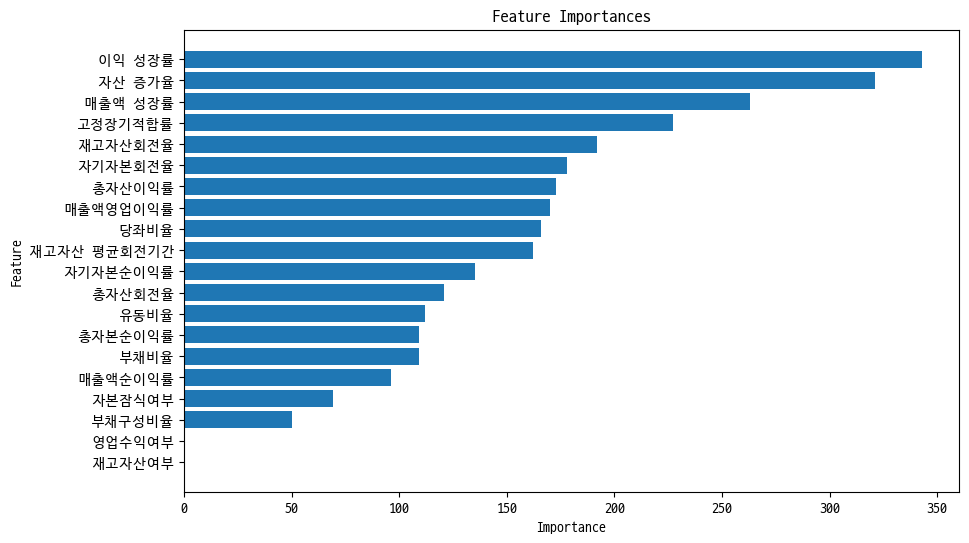

In [172]:
# 변수 중요도 계산
feature_importances = lgb_model.feature_importances_
feature_names = x_train.columns

# 변수 중요도를 데이터프레임으로 변환
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 중요도 순서로 정렬
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 중요도가 높은 특성이 위에 오도록 y축 반전
plt.show()

## Pycaret  
버전 충돌 등 이슈로 코랩에서 진행

# 모델링 결과 비교

In [469]:
# 모델 학습
models = [cat_model, ls_model, rf_model, lgb_model, xgb_model, et_model, dt_model]
model_names = ['CatBoost', 'LogisticRegression', 'RandomForest', 'LightGBM', 'XGBoost', 'ExtraTree', 'DecisionTree']

0:	learn: 0.6459917	total: 40.2ms	remaining: 30s
1:	learn: 0.6032117	total: 77.2ms	remaining: 28.7s
2:	learn: 0.5678914	total: 111ms	remaining: 27.6s
3:	learn: 0.5357935	total: 141ms	remaining: 26.2s
4:	learn: 0.5074858	total: 171ms	remaining: 25.3s
5:	learn: 0.4802932	total: 197ms	remaining: 24.3s
6:	learn: 0.4576010	total: 228ms	remaining: 24s
7:	learn: 0.4365974	total: 257ms	remaining: 23.7s
8:	learn: 0.4181435	total: 293ms	remaining: 24s
9:	learn: 0.4006497	total: 325ms	remaining: 23.9s
10:	learn: 0.3840236	total: 357ms	remaining: 23.8s
11:	learn: 0.3704638	total: 388ms	remaining: 23.7s
12:	learn: 0.3579182	total: 420ms	remaining: 23.7s
13:	learn: 0.3457335	total: 451ms	remaining: 23.6s
14:	learn: 0.3342731	total: 485ms	remaining: 23.6s
15:	learn: 0.3258608	total: 521ms	remaining: 23.8s
16:	learn: 0.3171933	total: 557ms	remaining: 23.9s
17:	learn: 0.3079336	total: 588ms	remaining: 23.8s
18:	learn: 0.2994200	total: 619ms	remaining: 23.7s
19:	learn: 0.2910836	total: 650ms	remaining: 

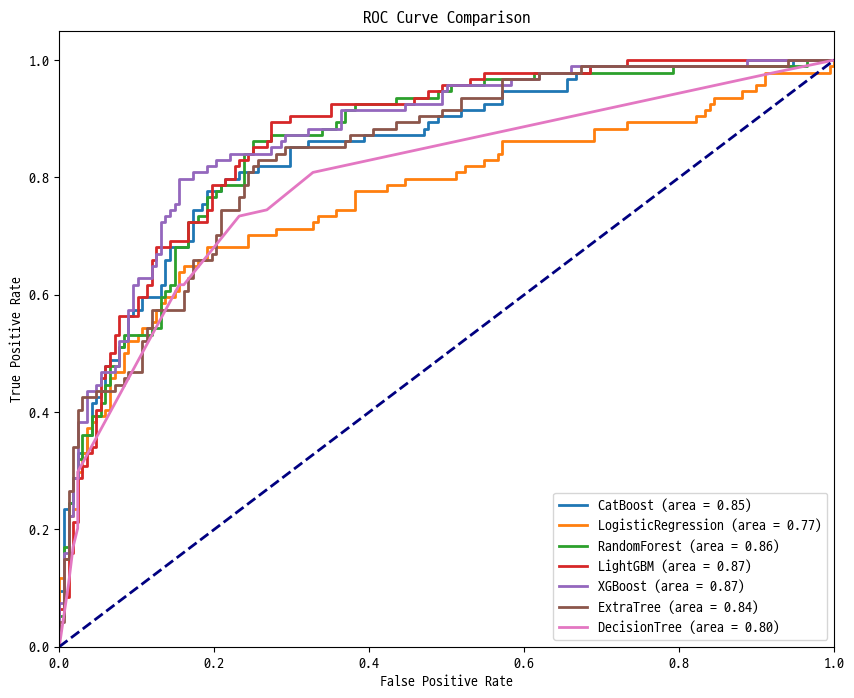

In [472]:
# ROC curve plotting
plt.figure(figsize=(10, 8))

# 모델 하나씩 학습하며 Auc커브 그래프 시각화
for model, name in zip(models, model_names):
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# 기대효과 및 한계점

## 기대효과  
- 투자자들이 기업의 관리종목 지정 가능성을 예측하고 합리적인 투자 의사결정을 하는데 기여
- 기업은 사전에 관리종목 지정 가능성을 인지하고 이를 피하기 위해 재무 건전성을 높이는데 집중
- 관리종목 지정은 기업의 주가 하락이나 평판에 부정적인 영향을 끼침 -> 상장폐지로 이어질 수 있음

## 한계 및 보완점  
- 변수를 1 년 단위로만 파악하여 연속적인 재무정보 반영하지 못함  
- 불성실공시, 감사의견 등 비재무적 요인에 대한 변수 고려하지 못함
- 업종 별로 데이터셋을 구분하지 못함